--- 
Final project for the course in Computational Statistics | Summer 2021, M.Sc. Economics, Bonn University | [Jonathan Willnow](https://github.com/JonathanWillnow)


# Partitioning and Hierachical Clustering and their Validation <a class="tocSkip">   
    
    
---
      


Xu,D., Tian,Y. A comprehensive Survey of Clustering Algorithms, Ann. Data. Sci 2, 165-193 (2015)      Minhua Chen et al(2021): Deep Clustering with Measure Propagation


##### Downloading and viewing this notebook:

* To view this notebook, the best way is to download the notebook which is contained in the repository on [GitHub](https://github.com/OpenSourceEconomics/ose-data-science-course-project-JonathanWillnow). Other viewing options like _MyBinder_ or _NBViewer_ may have issues with displaying images or coloring of certain parts (missing images can be viewed in the folder [files](https://github.com/OpenSourceEconomics/ose-data-science-course-project-JonathanWillnow) on GitHub).




## Library imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import pandas.io.formats.style
import seaborn as sns
import matplotlib.pyplot as plt
import itertools as tools
import scipy.stats as scipy
import sklearn.datasets as sk_data
import sklearn.cluster as sk_cluster
import sklearn_extra.cluster as skx_cluster
import sklearn.preprocessing as sk_preprocessing
import sklearn.metrics as sk_metrics
import random
import kneed


import time

from auxiliary.auxiliary import*
from IPython.display import HTML

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
%matplotlib inline
#sns.set_context('talk')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.25, 's' : 50, 'linewidths':0}

---
# Table of Contents
---

 1. [Introduction](#introduction)
 2. [The Tracking Underreported Financial Flows (TUFF) methodology](#section2)
 3. [Descriptive Statistics & Allocation of Chinese Development Finance](#section3)
   * 3.1 [The Distribution of Project Types](#section3.1)
   * 3.2 [Sectoral Distribution](#section3.2)  
   *  3.3 [Finance Form of Projects](#section3.3)  
   *  3.4 [Cross-country Distribution of Chinese Development Finance](#section3.4)  
   *  3.5 [Factors that determined Allocation of Chinese Development Finance](#section3.5)  
       *  3.5.1 [Extension - Descriptive Plots](#section3.5.1)  
       *  3.5.2 [Physical Project Inputs](#section3.5.2)  
       *  3.5.3 [Foreign Exchange Reserves](#section3.5.3)
   *  3.6 [Mixed Effect Models](#section3.6) 
 4. [Identification](#section4)
 5. [Empirical Strategy](#section5)
    *  5.1 [IV Strategy](#section5.1)
    *  5.2 [Checking Parallel Trends Assumption](#section5.2)
 6. [Does Chinese Development Finance Promote Growth?](#section6)
    *  6.1 [Main Results](#section5.1)
    *  6.2 [Extension - Visual Representation of Results](#section6.2)
    *  6.3 [ Extension - Checking Instrument Validity](#section6.3)
    *  6.4 [Timing of the Growth Effects](#section6.4)
    *  6.5 [How does Chinese Development Finance cause Growth?](#section6.5)
    *  6.6 [Robustness Checks](#section6.6)
 7. [Conclusion](#section7)
 8. [References and Literature](#section8)







# Introduction to Clustering

Every day, large amounts of data are collected by many heterogenous individuals. To create information from this data, clustering is an essential part in the process to identify patterns or groups within the collected data. For instance consider the database of a food-delivery chain that records purchases of its customers. An appropriate clustierng algorithm could group the customers by similar patterns within their order history. This could provide a deeper understanding of the demand side.
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf
Clustering poses special challenges: Unlike other methods in Data Science, clustering does not try to predict an output. We only observe the input variables, but not the output variable. 




### What is a Cluster

Clusters are loosely defined as groups of data objects that are more similar to other objects in their cluster than they are to data objects in other clusters. In practice, clustering helps identify two qualities of data:

**Meaningfulness**

> Clusters that are meaningful expand the users domain knowledge. 

**Usefulness**

> Useful clusters serve as an intermediate step in a data pipeline. For example, businesses use clustering for customer segmentation. The clustering results segment customers into groups with similar purchase histories, which businesses can then use to create targeted advertising campaigns.

# Apply own example for Usefulness and Meaningfullness

Since the choice of feature types and measurement levels depends on the data, many clustering algorithms have been developed. 
https://www.intechopen.com/chapters/60501

In fact, there are so many approaches that entire categories of clustering algorithms exists. Each of these categories has its own unique strengths and weaknesses. Certain clustering algorithms will result in more natural cluster assignments depending on the input data, some are better at detecting unusual shapes of clusters.

The whole process of clustering is illustrated in the following picture:


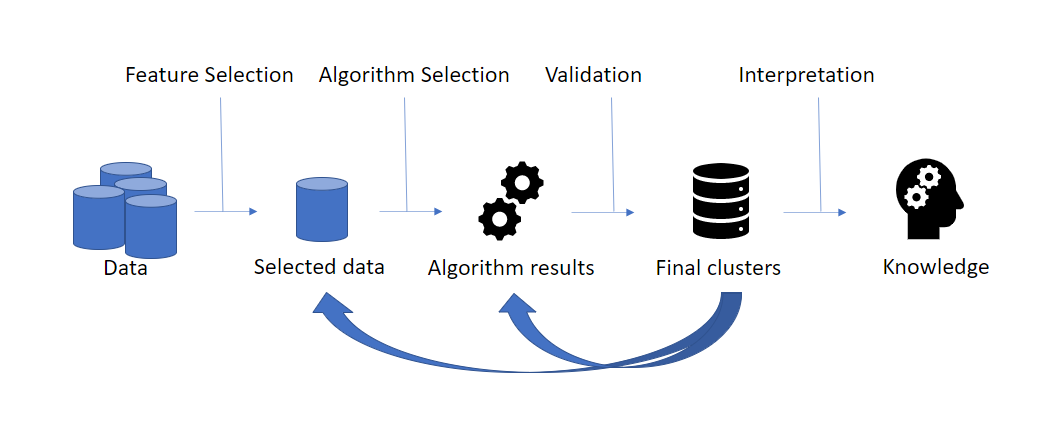
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf


http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf

Selecting the right features and an appropriate clustering algorithm for the data at hand is often times quite difficult. There are so many choices to make, depending on the characteristics of the clusters, the features of the dataset, the number of outliers, and the number of data objects. Thats not all as the user still needs to validate his results and finally interpret them.

https://realpython.com/k-means-clustering-python/


Clustering is a major tool in many fields. It can be used for different sorts of applications:

>* Data reduction. Clustering helps to compress the information included in a dataset, especially when the amount of available data is large and the processing of the whole data becomes very unfeasible. Applying clustering helps to reduce the dataset into a number of clusters wich can than be processed on further.

>* Hypothesis generation. Clustering can be used to infer some hypotheses concerning the data at hand. In our example from earlier on, we find out that the business has three significant groups of customers. Based on this three clusters, we can set up hypothesis about their behaviour (Older individuals tend to pay cash,...)

>* Hypothesis testing / verification. Clustering is used to validate  a specific hypothesis. Considering the hypothesis from before (Older individuals tend to pay cash), clustering can suport this hypothesis if it forms a cluster that coresponds to the hypothesis.

>* Prediction based on groups. Clustering forms clusters that can be characterized by the features of the observations that belong to these clusters. New observations, for instance new customers can be assigned into these specified clusters based on their similarity to the clusters’ features. This helps to extract knowledge that is related the data.



## Distance Measuring

Before jumping into the different algorithms for clustering, it is helpful to reconsider how to measure the distances of elements relative to each other in order to decide which elements belong in which group. A distance between any pair of elements or vectors satisfies four porperties:

>1. Symmetrie, $d(i,j) = d(j,i)$

>2. Poitive Definiteness, $d(i,j) > 0$ and $d(i,j) = 0$ if and only if $i=j$

>3. Triangel Inequality, $d(i,j) <= d(i,k) + d(k,j)$

From these assumptions follows the Minkowskie distance, which is the traditional way to measure distances:

The Minkowski distance with order p between two elements (or vectors) $i,j$ is defined as:



\begin{equation}
D(i,j) = (|i - j|^p)^{(1/p)}
\end{equation}


taking $p$ = 1 we have the Manhattan distance, also know as taxi-cab distance and with $p$ = 2 we have the Euclidean distance. For most common hierachical clustering, the Euclidean distance is the go to distance.
http://i2pc.es/coss/Docencia/SignalProcessingReviews/Murtagh2012.pdf


# Clustering Methods - an Overview

## Data and Preparations

For the introduction of the algorithms, I created two types of simulated random samples.

* The first data sample is created using the scikit-learn function _make_blobs()_, which generates isotropic Gaussian blobs for clustering. As can be seen in the following plot, the function allows us to access the true ground truth labels.


* The second data sample is created differently as I simulate spiral data that is then used to run the algorithms. The ground truth labels of this generated dataset are unknown. The purpose of this second data set is that the reader gains intuition about the differnt algorithms and their strenghts and weaknesses by looking at the clustering results for two very different data sets.


After the data generation of the two data sets, the data needs to be standardized, since in a real world context the dataset would most likely contain features measured in different units. Since the standardization of the spiral dataset would destroy the spiral structure of the dataset, I decided to only standardize the dataset that contains the isotropic blobs

In [4]:
random.seed(10)

In [5]:
blobs_df = generate_blobs(500, centers=3, cluster_std=3, random_state=10)

In [6]:
complex_data = generate_spiraldata(500, False)

##### Plotting the generated and standardized datasets

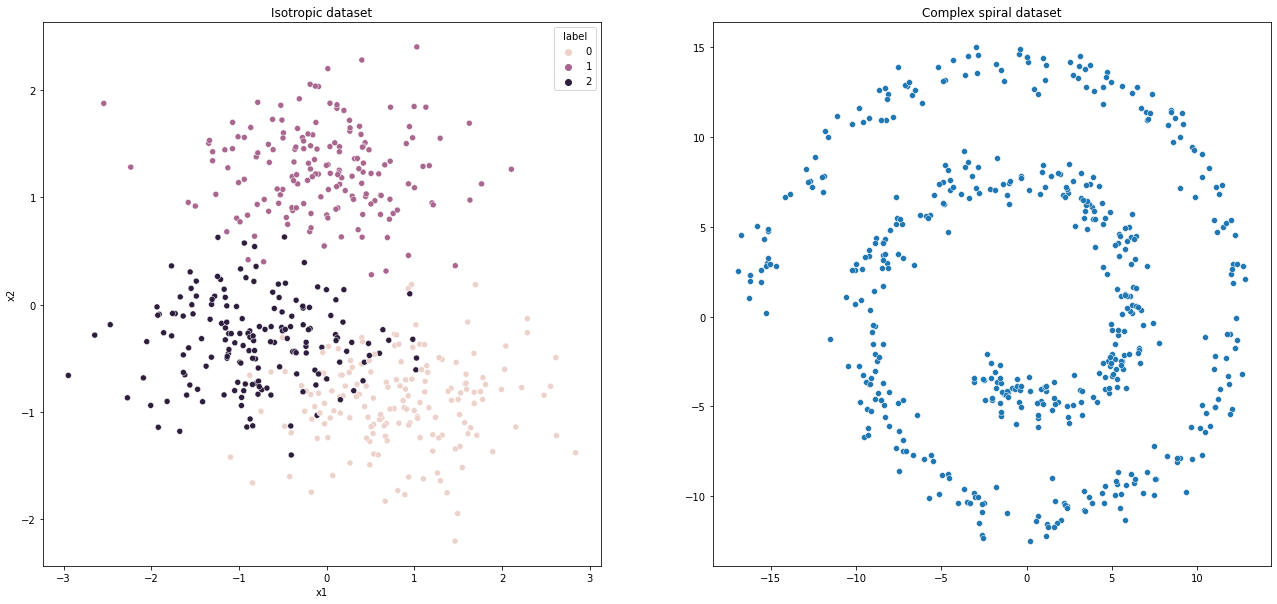

In [7]:
plot_generated_datasets(complex_data, blobs_df)

# Partitioning and Hierachical Clustering methods

Figure 1 displays the difference between partitional clustering (b) and hierachical clustering (c) of a dataset (a). There are two more categories, Density-based clustering and Grid-based clustering. As the title suggests, this notebook explores the first two aformentioned categories. I will explore several methods for partitioning and hierachical clustering and their validation. 
http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.97.6607&rep=rep1&type=pdf



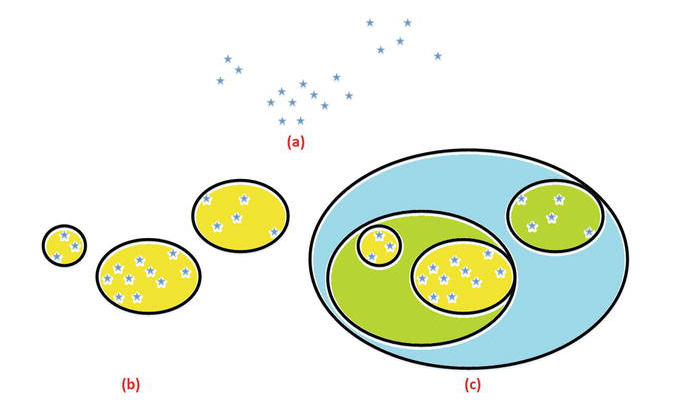

https://www.intechopen.com/chapters/60501


## Partitioning Clustering methods

Partitional clustering algorithms are methods used to classify data objects into multiple groups, with at minimum one element per group, based on their similarity. This is done in an intertive pocess. No object can be a member of more than one cluster. For some of theclustering algorithms of this categorie (K-Means, K-Medoids), the scientist has to specify $k$ - the number of clusters.

I will focus on four algorithms, K-Means clustering, K-Medoids clustering, Affinity Propagation Clustering, and Mean Shift clustering. Only Affinity Propagation is deterministic over runs. This simply means that when using the non-deterministic algorithms, the user could obtain different results when running the same algorithm several times over the same dataset.

Partitional clustering methods have several strengths:

+ They work well when clusters have a spherical shape.
+ They’re scalable with respect to algorithm complexity.

They also have several weaknesses:

+ They’re not well suited for clusters with complex shapes and different sizes.
+ They break down when used with clusters of different densities.
https://realpython.com/k-means-clustering-python/

### K means

K-means clutering was introduced by J. MacQueen in 1967 when he was proposing algorithms that can "paritioning an N-dimensional population into k sets" (MacQueen 1967). According to MacQueen, this algorithm produces partitions that are reasonably efficient in their within-class variance, is easily implemented and not to computationally extensice. (MacQueen) In the following section we will see that this algorithm is scaling well to large number of samples.

As explained in Section 4, as a algorithm that is performing partitional clustering, the k-means algorithm clusters $n$ objects of the dataset $X$ by trying to partition them in $k$ groups $C$ of equal variance, minimizing a criterion known as the inertia or within-cluster sum-of-squares. The so called cost function of the k-means algorithm is the follwing: 

\begin{equation}
\sum_{i=0}^n \min_{\mu_j \in C}(||{x_i}-{\mu_j}||^2)
\end{equation}

It is defined in terms of the squared euclidean distance of each point $x_i$ to the closest cluster mean.
MIT https://piazza.com/class_profile/get_resource/hckx35ial496d5/he8g2d4n99u6ic

This requires to specify the number of clusters. The inertia criterion leads to the algorithm suffering regarding several drawbacks:
* Inertia assumes that true clusters are convex and isotropic. So it assumes globular clusters, whereas in reality this is not always the case. It is therefore not suitable for clusters with unusual shapes.

* Inertia is not normalized, meaning that we just know that a Inertia of 0 is optimal, but we cannot compare the inertia that we obtained by k-means clustering across several datasets. This is especially true for the high dimensional space, where the euclidean distance becomes inflated when the algorithm tries to learn the structur of a high dimensional dataset from a small number of observations.
https://scikit-learn.org/stable/modules/clustering.html#


Given a specified inital set of k-means $m_1$,...$m_k$, Lloyds algorithm proceeds as follows:

---
<span style="color:blue">**Llyods algorithm**:</span> 

   1. **Initialization**: The initial k-centroids are randomly picked from the dataset
   2. **Assignment**: For each point in the dataset, find the euclidean distance between the point and all centroids
   3. **Updating**: Update the value of the centroid with the new mean value
   4. **Repeat**: Repeat steps 2 and 3 until convergence is archieved. The break the loop


---

https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca




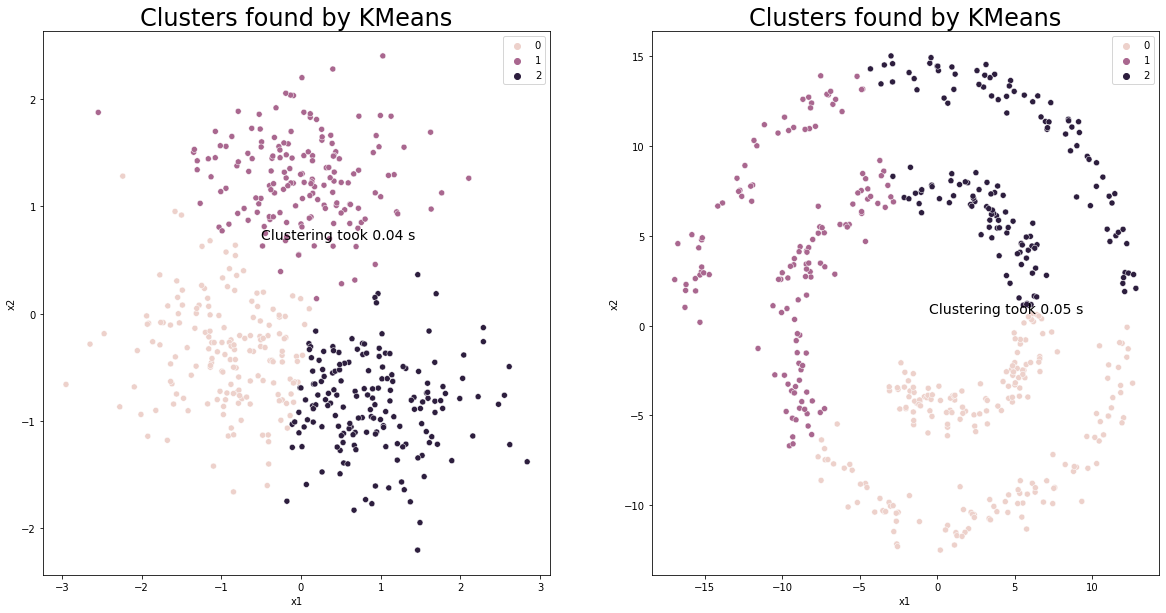

In [8]:
k_means = plot_clusters(blobs_df, complex_data, sk_cluster.KMeans, (), {'n_clusters':3,  "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42})


## K Medoids

K-Medoids clustering tackles a problem of K-Means clustering: IN K-Means Clustering, the final centroids are not interpretable since these centroids are not actuall points but the mean of all the points that were partitioned into that cluster. Therefore the coordinates of the centroids do not resemlbe reals points. K-Medoids clustering tackles this and makes the final centroids actual datapoints, which makes the final centroid intertrepatble.

The algorithm used for k-medoids clusterig is called the Partitioning Around Medoids Algorithm (PAM). It uses a greedy search which may not reuslt in the optimum solution, but is really fast. PAM proceeds as follows:

---
<span style="color:blue">**Partitioning Around Medoids Algorithm (PAM)**:</span> 

   1. **Initialization**: The initial k-medoids are randomly picked from the dataset
   2. **Assignment**: For each point in the dataset, find the euclidean distance between the point and all medoids and associate each point to the closest medoid
   3. **Updating**: Choose new centroid $M$ such that it minimizes the minimum cost function:

\begin{equation}
M_1, M_2, ..., M_k = argmin \sum_{i=1}^k \sum_{i=1} ||x-M_i||^2)
\end{equation}

   4. **Repeat**: Repeat steps 2 and 3 until convergence is archieved. The break the loop

---

https://piazza.com/class_profile/get_resource/hckx35ial496d5/he8g2d4n99u6ic

https://towardsdatascience.com/understanding-k-means-k-means-and-k-medoids-clustering-algorithms-ad9c9fbf47ca

or in other words, centroids are not the actual point but the mean of points present in that cluster. Here are the coordinates of 3-centroids that do not resemble real points from the dataset.

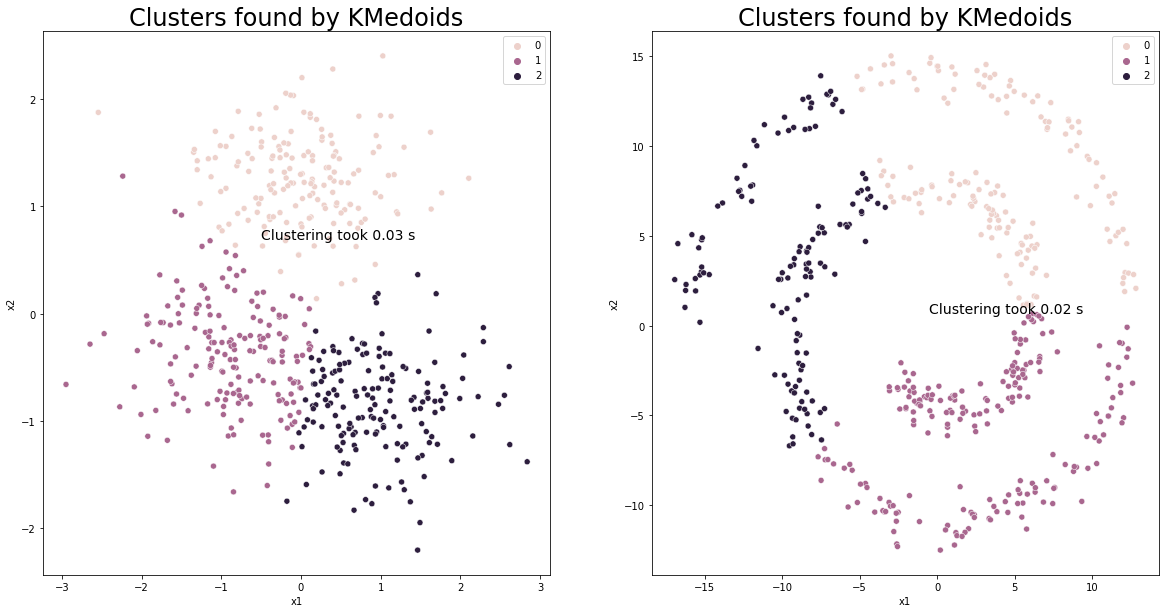

In [9]:
K_medoids = plot_clusters(blobs_df, complex_data, skx_cluster.KMedoids, (), {'n_clusters':3,  "init": "random", "max_iter": 300, "random_state": 42})

## Affinity Propagation

Affinity Propagation is a newer and modern clustering algorithm that uses a graph based approach. It aims to discover the datappoints taht represent the whole dataset. This is done since the algorithm let the points ‘vote’ themselves on their preferred ‘exemplar’ based on the maximal value of the responsibility and availability of each data point. Responsibility of a data point refers to wheter it is suited to be assigned to an exemplar; Availability measures how well a data point is suiteed to be an exemplar.

https://digitalcommons.georgiasouthern.edu/cgi/viewcontent.cgi?article=3029&context=etd

This is done by passing messages between the data points until these maximums are archieved. We do not need to specify $k$ since the optimal number of clusters is computed through updating the responsibility and availability of all data points of the dataset. The algorithm then returns data points as a set of ‘exemplars’ from which the clusters are then created similar to what K-Means does: Each point is assigned to the cluster of it’s nearest exemplar. 
https://digitalcommons.georgiasouthern.edu/cgi/viewcontent.cgi?article=3029&context=etd

Affinity Propagation has some advantages over K-Means:

* First, since the points vote themselves on their preferred exemplars, the user doesn’t need to specify the number of clusters. 

* Second, the algorithm allows for non-metric dissimilarities which is important if the user wants to work with data that is not naturally embedded in a metric space

* Finally, Affinity Propagation offers better stability runs

Since Affinity Propagation partitions the data, problems with 'noisy' data can be expected. In addition to this, Affinity Propagations needs the user to specify 'preference' and 'damping' parameters, which can be challenging. Additionally, since the algorithm supports non-metric dissimilarities, it tends to be slow. Overall, Affinity Propagation does not really provide an improvement in normal settings unless the choice of the specific preference and damping parameters are easier than specify the number of clusters.
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#

Because the algorithm works without specifying $k$ initial clusters, there is no application for the elbow and silhouette method.
https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html#mean-shift

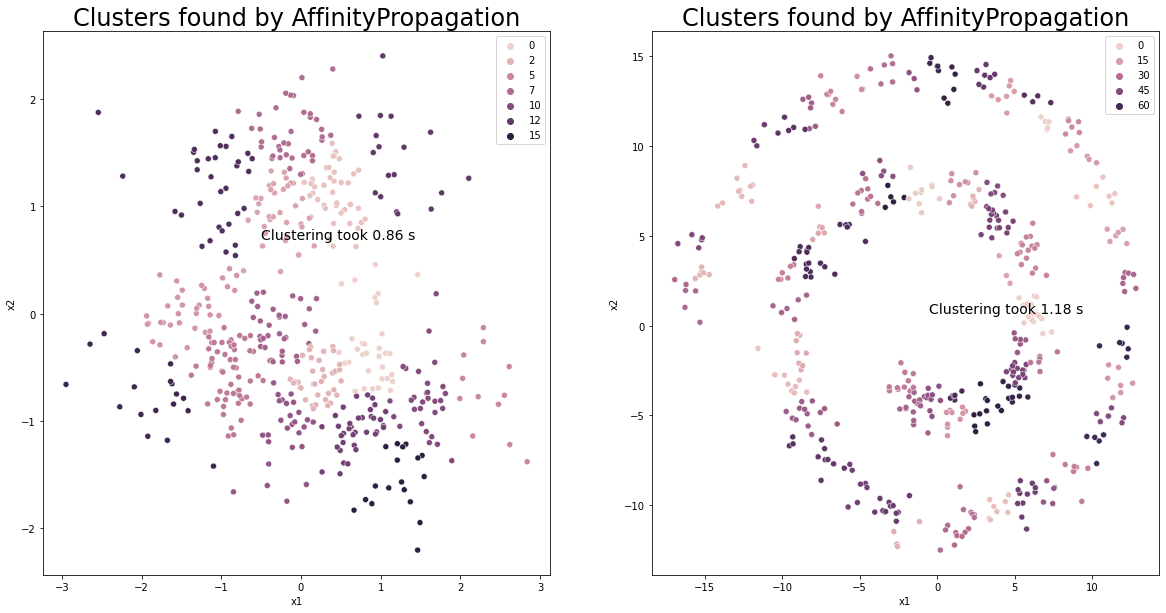

In [10]:
xx= plot_clusters(blobs_df, complex_data, sk_cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95, "max_iter": 400, "random_state": 42})

## Mean Shift Clustering

This algorithm aims to discover blobs in a sample. Like K-Means, it is a centroid based algorithm. It works by updating candidates for centroids to be the means of points within a given region. 

It uses a kernel function $K(x_i - x)$ which determines the weights of all points near the centroid for the computation of the mean. You can think about this kernel as a circular sliding window with the a radius that is determined by the bandwith parameter. In the implementation at hand, if this bandwith parameter is not specified it is estimated within the function.

Given a centroid $x_i$ at iteration t, it is updated according to

\begin{equation}
x_i^{t+1} = m(x_i^t) = \frac {\sum_{x_j^t \in N(x_i^t)} K(x_j^t - x_i^t)x_j^t} {\sum_{x_j^t \in N(x_i^t)} K(x_j^t - x_i^t)}
\end{equation}

with $N(x_i)$ as the neighborhood of samples that lie within a given distance arround $x_i$ and $m$

---
<span style="color:blue">**Mean Shift Clustering Algorithm**:</span> 

   1. **Initialization**: The initial centroids are randomly picked from the dataset according to the parameters. 
   2. **Assignment**: Calculate the mean of all points that lie within the "window"
   3. **Updating**: Choose new centroid $M$ such that the window is lying on the location of the mean.
   4. **Repeat**: Repeat steps 2 and 3 until convergence (current location of window and new centroid coincides) is archieved. Then break the loop.

---

As you see below, the user can instruct the algorithm to label orphans with the label _-1_. Orphans are defined as points that do not lie within a kernel. 

##### Positive Aspects:
* User does not have to specify the number of clusters
* Output not dependedn on initialization
* Simple implementation in Python: Bandwith parameter (radius of kernel) is estimated within the function if not specified

##### Negative Aspects
* Self-selection of Bandwith not trivial!
* Designed to detect "blobs" within data, struggles with complex data structures

https://iq.opengenus.org/mean-shift-clustering-algorithm/

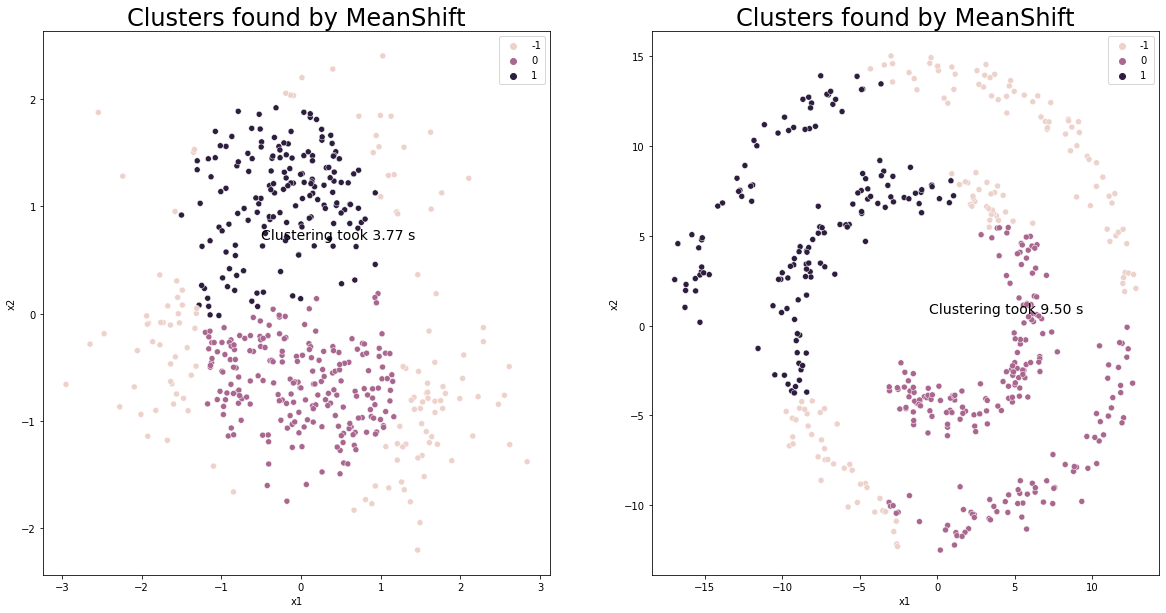

In [11]:
xxx= plot_clusters(blobs_df, complex_data, sk_cluster.MeanShift, {}, {'cluster_all':False});

Please note that I specified _cluster_all_ to be _False_.
If true, then all points are clustered, even those orphans that are not within any kernel. Orphans are assigned to the nearest kernel. If False, then orphans are given cluster label -1. 

## Hierachial Clustering

Hierarchical clustering determines cluster assignments by building a hierarchy. The data is first clustered in some subgroups. This is implemented by either a bottom-up or a top-down approach. There are two families of hierachical clustering algorithms:

* Agglomerative clustering is the bottom-up approach as one moves up in the hierachy. It merges the two points that are the most similar until all points have been merged into a single cluster or the desired number of clusters is obtained.

---
<span style="color:blue">**Agglomerative Clustering**:</span> 

   1. All data points are in their own cluster
   2. Two nearest clusters are joined to form single cluster
   3. Repeat step 2 until until desired number of clusters is obtained

---

* Divisive clustering is the top-down approach. It starts with all points as one cluster and splits the least similar clusters at each step until only single data points remain.

---
<span style="color:blue">**Divisive Clustering**:</span> 

   1. All data points are assigne in one single cluster
   2. Cluster is partitioned into two least similar clusters
   3. Repeat step 2 to form new clusters until desired number of clusters is obtained

---



Python only provides Agglomerative Clustering algorithms in its libraries. So in the following I will focus only on the bottom-up approach of hierachical clustering. The algorithms of the families differ in their linkage criterion.
https://coderzcolumn.com/tutorials/machine-learning/scikit-learn-sklearn-hierarchical-clustering
There are several different metrics used for the linkage:

* Ward - minimizes the summ of squared differences within all clusters
* Maximum / Complete linkage - minimizes the maximum distance between observations of pairs of clusters
* Average linkage - minimizes average of the distances between all observations of pairs of clusters
* Single linkage - minimizes distance between closest observations of pairs of clusters

The hierachical structure of the results can be represented using a dendrogramm. This provides a tool that is useful for understanding the structure of the data.


https://scikit-learn.org/stable/modules/clustering.html


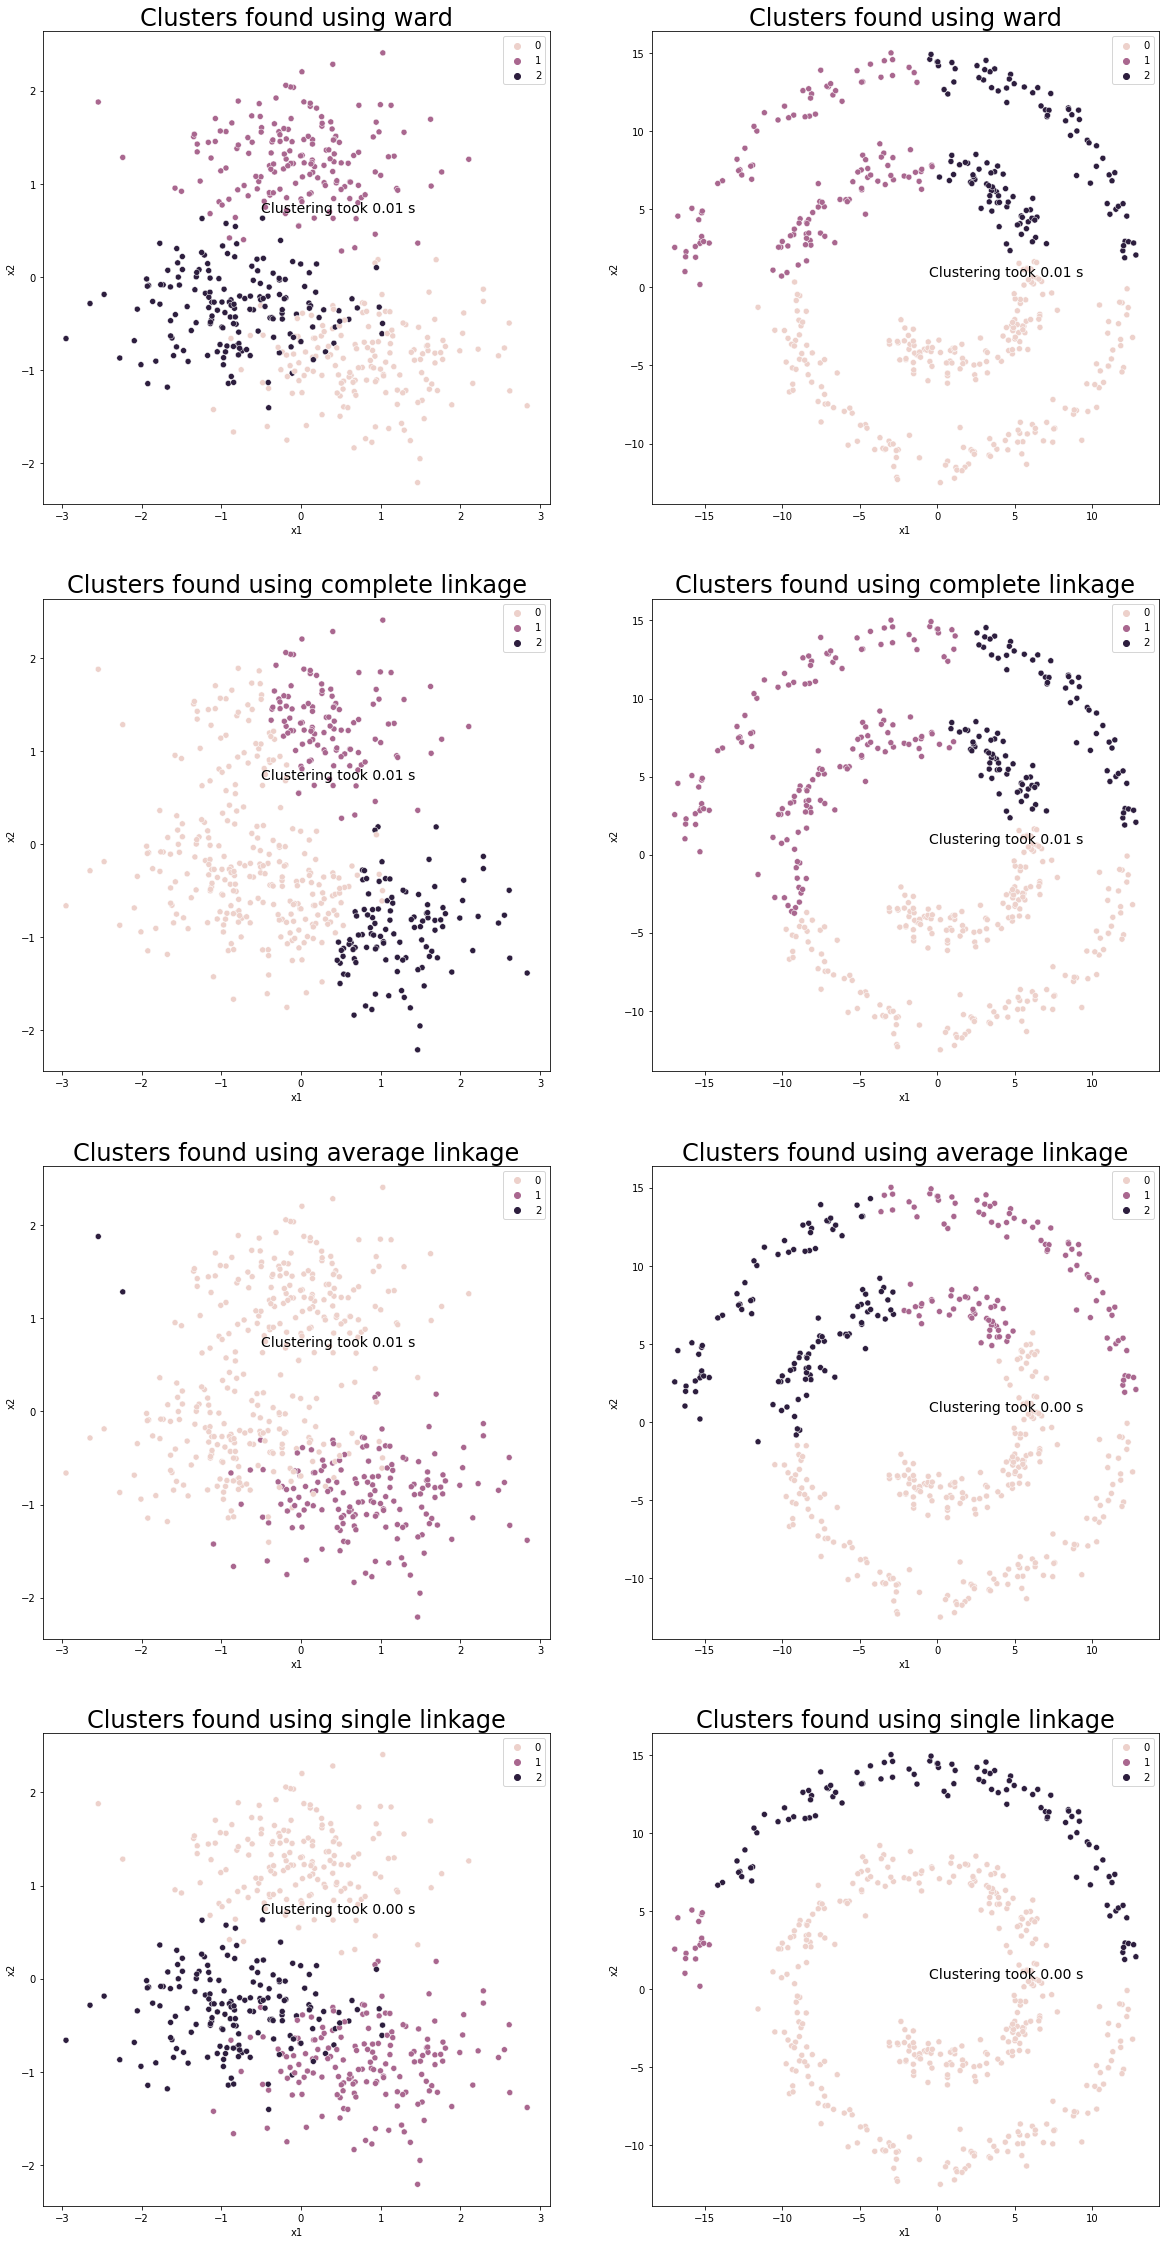

In [12]:
plot_Agglomerative_clusters(blobs_df, complex_data, 3, ())

# Validation

The most important issue in clustering is to evaluate the results to identify the clusters that fit the data the best. Evaluating this is not as simple as calculating metrics like the Mean-Squared Error as in supervised machine learning. 
Optimally, clustering identifys clusters whose members are similar and well seperated from other clusters. Visualization is key, thats why I invested time in plotting and visualizing all the different algorithms that I introduced. Different algorithms differ regarding:

* feature of data


* parameters choosen or estimated by user

##### There are three ways to investigate cluster validity.

##### External Validation

> "The obtained clusters correspond with my intuition about the topic"

The user evaluates the results of his analysis based on a pre-specified structure, which is imposed on a data set and reflects our intuition about the structure. An example of external validation is when the user somehow know the true clusters (has intuition) in the data. External validation then looks on how accurately the clustering method is able to uncover the real clusters.


##### Internal Validation

> "The choosen method gives me the clearest, seperated and best connected clusters"

The user evaluates the results in terms of quantities that are set by the algorithm and the dataset themselves. It is often used to estimate the number of clusters when there are no external informations at hand. Another example is when the user makes certain assumptions about the data such that a certain method fits the data the best.
Some often reflected measurements regard:

  * Compactness - How close are objects within the same cluster / how similar are the objects?
  
  * Separaition - How well seperated are clusters from each other?
  
  * Connectivity - How probalble is it that nearest neighbors are placed in the same cluster?
    
    
##### Relative Validation

> "This parameter specification give me the most separated and compact clusters out of all specifications"

The user evaluates the structure of his result by comparing it to other clustering results that are calculated by the same algorithm but with different parameter values. The comparison is done with respect to:

  * Compactness - the distances of observations within a cluster should be as small as possible 
    
  * Separation - the clusters themselves are optimally widely spreaded
    
    
https://scikit-learn.org/stable/modules/clustering.html#davies-bouldin-index

https://www.datanovia.com/en/lessons/cluster-validation-statistics-must-know-methods/

https://realpython.com/k-means-clustering-python/


**After providing some intuition about the different validation approaches, I will introduce some methods.**

### The Elbow Method


This method identifies the optimal number of clusters that the researcher should coose for the data at hand and is therefore used for interal validation. To perform the elbow method, run several k-means, increment k with each iteration, and record the SSE. After this we use the SSE to determine the elbow point. Since this is not always straightforward, the user most often identifies the elbow point programmatically. I use the Python package _kneed_ later on in my implementation.
https://realpython.com/k-means-clustering-python/


### The Silhouette Coefficient

The silhouette coefficient is a measure of cluster cohesion and separation and is used when the ground truth labels are not known. It quantifies how well a data point fits into its assigned cluster based on two factors:

* $a$: The mean distance between a sample and all other points in the same class.

* $b$: The mean distance between a sample and all other points in the next nearest cluster.

The coefficient for a single observation is:

\begin{equation}
s = \frac {b - a} {max(a,b)}
\end{equation}

Silhouette coefficient values range between -1 and 1 where a higher Silhouette Coefficient score relates to a model with better defined clusters and dense clustering. A score of -1 indicates incorrect clustering, a score arround zero shows overlapping clusters. Keep in mind that this coefficient is higher for convex clusters. 
https://realpython.com/k-means-clustering-python/

##### The following function performs k-means clustering and uses both methods to evaluate the appropriate cluster based on different generated datasets:


In [13]:
kmeans_kwargs = { "init": "random", "n_init": 10, "max_iter": 300, "random_state": 42,}

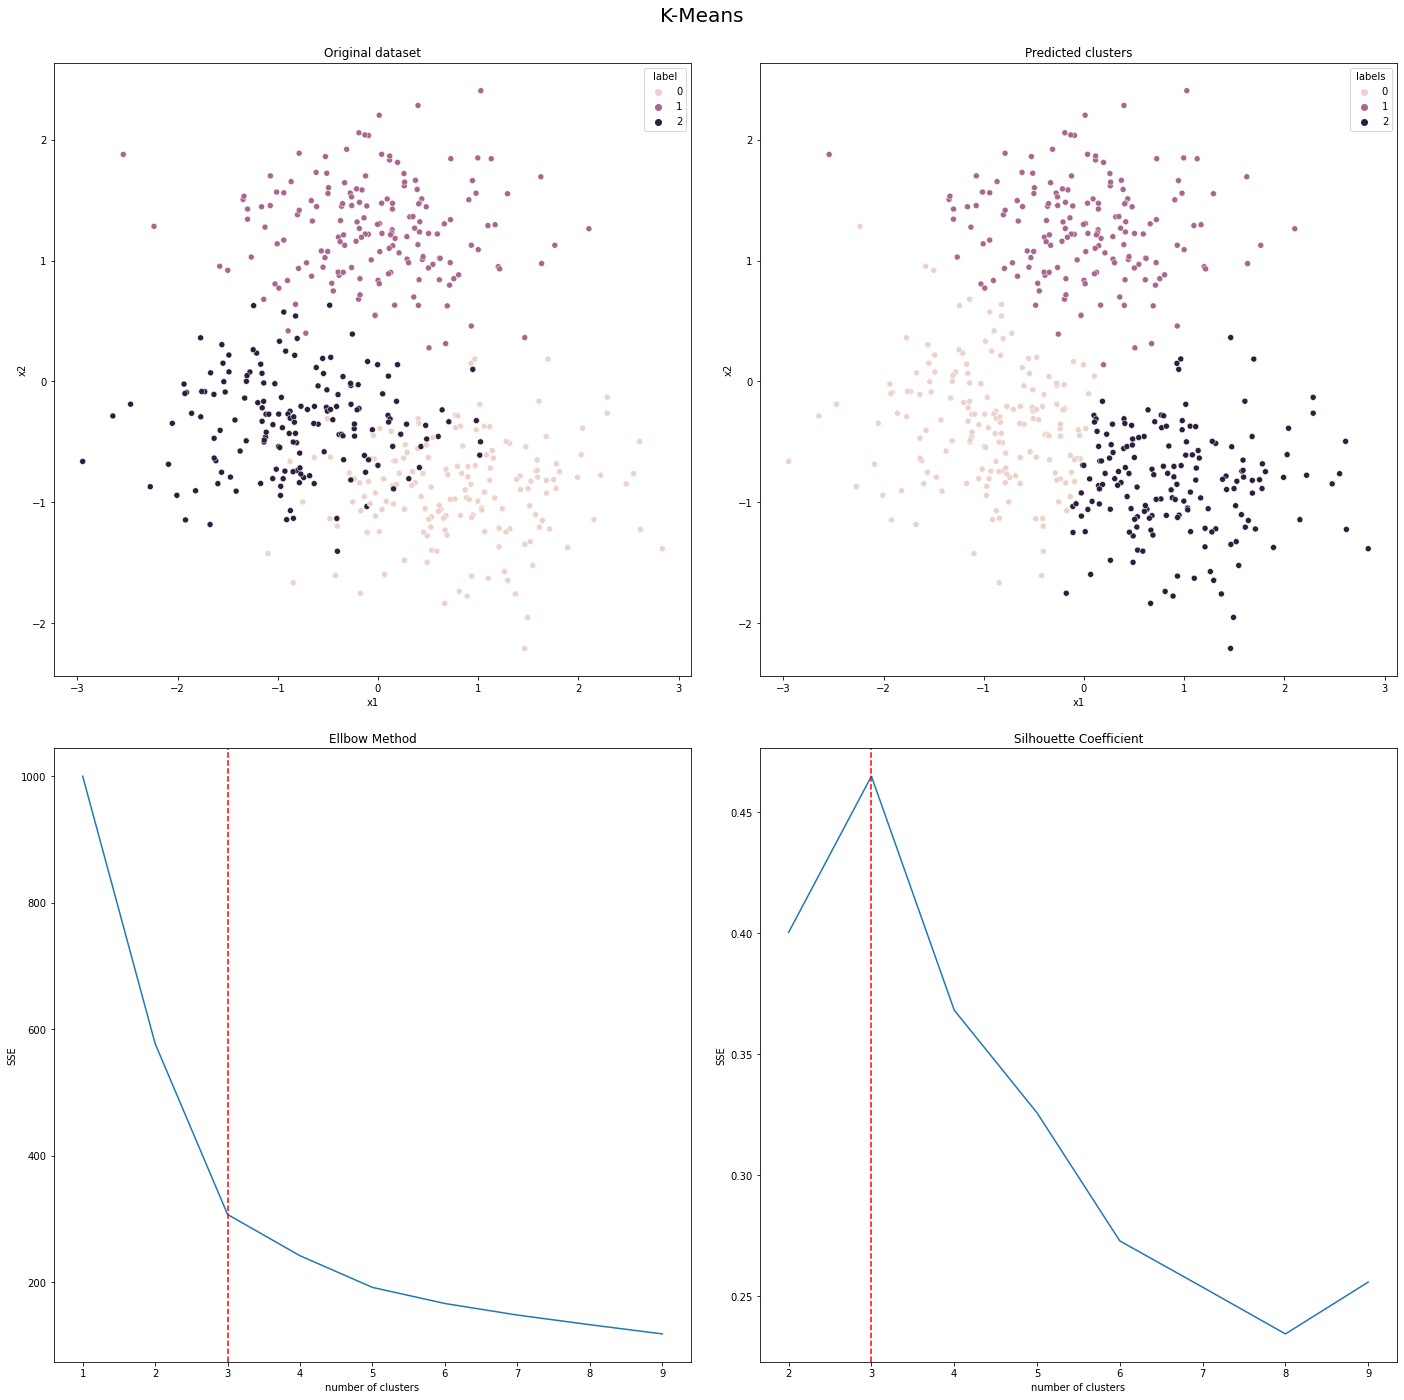

In [14]:
kmeans_validation_example(kmeans_kwargs, 10, blobs_df);
   

https://realpython.com/k-means-clustering-python/

https://scikit-learn-extra.readthedocs.io/en/stable/modules/cluster.html#k-medoids

In [15]:
kmedoids_kwargs = { "init": "random", "max_iter": 300, "random_state": 42,}

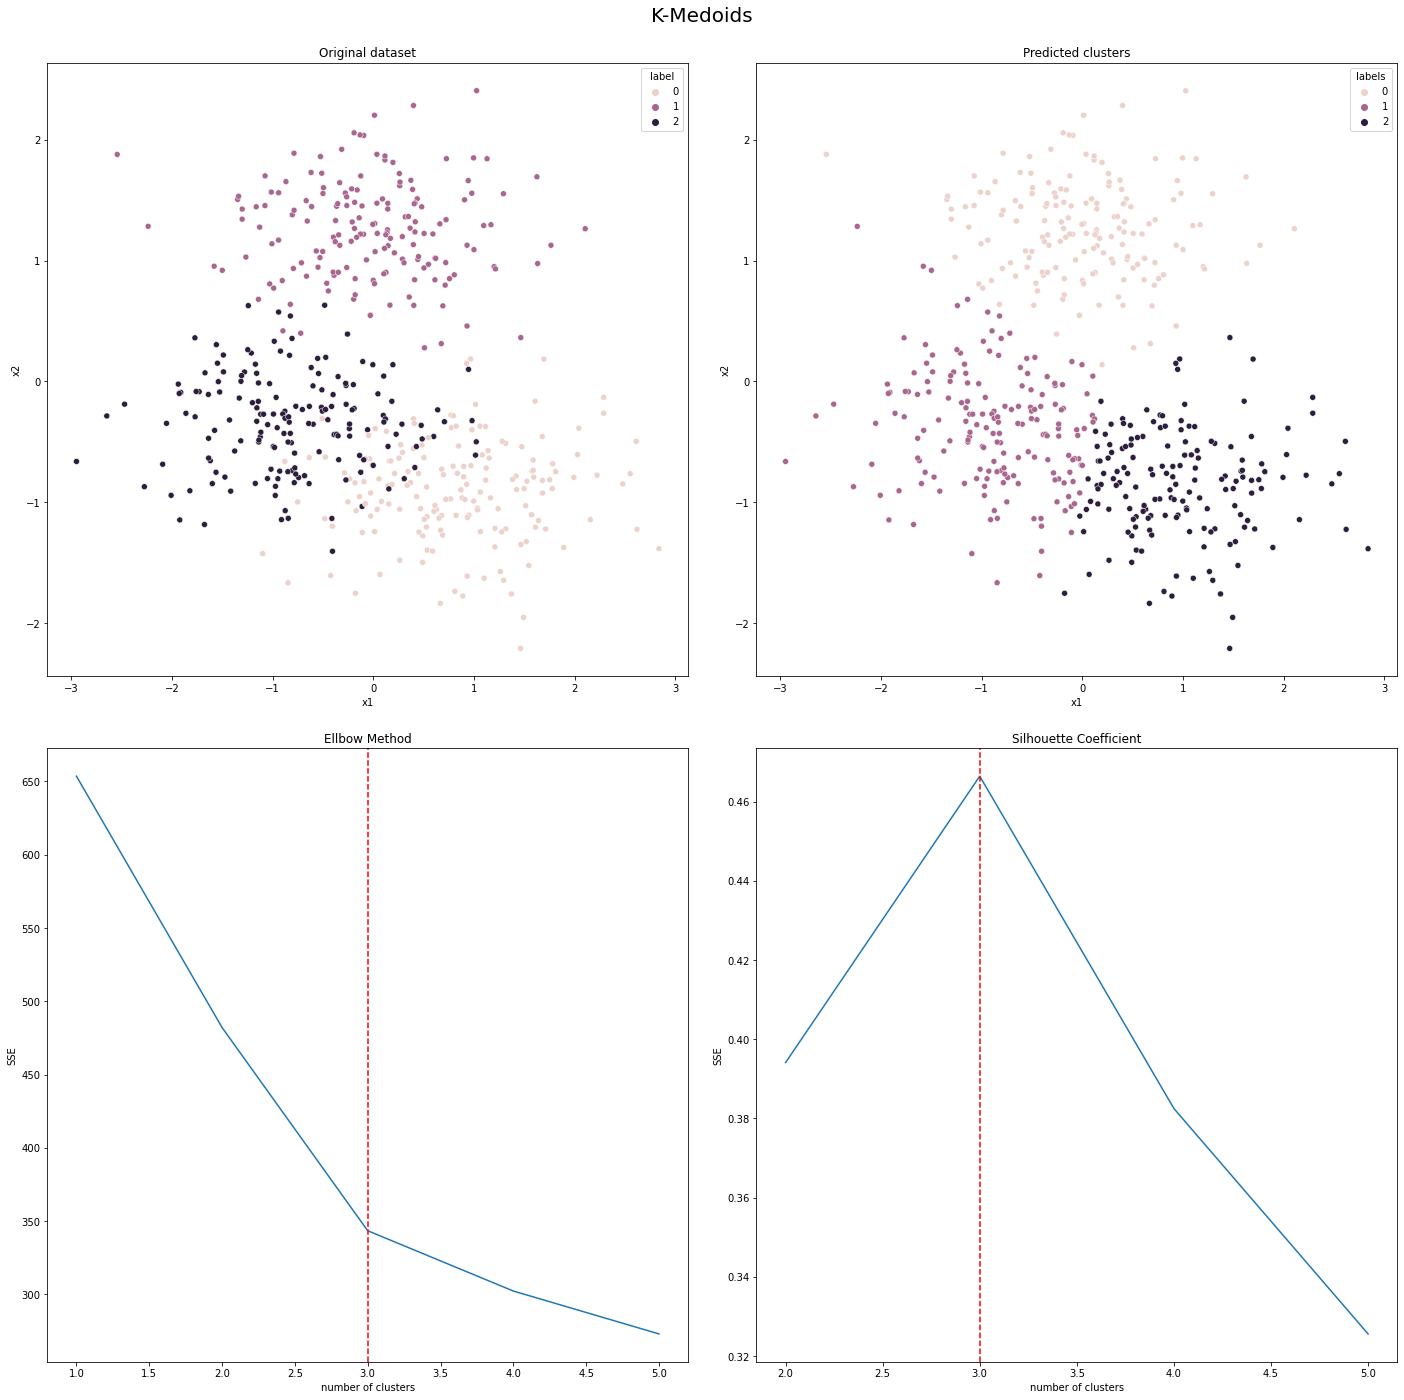

In [16]:
kmedoids_validation_example(kmedoids_kwargs, 6, blobs_df)

### Davies-Bouldin Index

As for the silhouette coefficient, when the ground truth labels are not known,this index can be used to evaluate the model. A lower Davies-Bouldin index relates to a model with better separation between the clusters. The Davies-Bouldin Index measures the average similarity between the clusters (similarity is thereby measured by comparing the size of the clusters with the distance between the clusters).

Define

* $s_j$, the average distance between each point of cluster $i$ and the centroid of that cluster

* $d_i,$, the distance between the centroids of cluster $i$ and cluster $j$.


\begin{equation}
DB = \frac {1} {k} \sum_{i=1}^k max_{i!=j} (\frac {s_i + s_j} {d_ij})
\end{equation}
    
    
### Fowlkes-Mallows Index

This index can be used when the ground truth labels are known. The Fowlkes-Mallows index is the geometric mean of the pairwise precision of the model.

* $TP$ are True Positives (pairs of points that belong to the same clusters in both the true labels and the predicted labels)

* $FP$ are False Positives (number of pair of points that belong to the same clusters in the true labels and not in the predicted labels)

* $FN$ are False Negatives (number of pair of points that belongs in the same clusters in the predicted labels and not in the true labels)


\begin{equation}
FMI = \frac {TP} {\sqrt{(TP + FP)(TP + FN)}} 
\end{equation}

The index ranges from 0 to 1. The higher the score, the higher is the similarity between the true labels and the predicted labels. A index of 0 indicates purely independent label assignement, an index of 1 indicates that the label assignments are equal. An advantage of the FMI is that it does not make any assumptions about the structure of the clusters.





## Performance and Scaling

So far I described several clustering algorithms. This ection will shed light on the issue of performance and scalability. Some might thik tht this topic does not really matter nowadays, but as I will show, it still does for some algorithms that we discussed. 

Performance and Scalability depends both on the algorithm itself, but also on the implementation. Obviously a well written implementation in C or C++ will beat my implementation with Pyton. But besides the choice of the language that we use, there are other factors that have a large impact on the performance. The structure of the dataset at hand impacts the performance by a large amount, and can even significanty change asymptotic performance. So for some researchers with limited computational resources or for Data Scientist that have to process hugh amounts of data everyday, this poses a serious constraint to the range of clustering algorithms that are feasible for them.

To provide a comparison of the clustering algorithms with regard to the performance and scaleability, I coded a benchmarking function that gives us the performance for each algorithm with varying dataset sizes. Because some clustering algorithms have performance that can vary quite a lot depending on the exact nature of the dataset we’ll also need to run several times on randomly generated datasets of each size so as to get a better idea of the average case performance.----


In [17]:
kwargs_random = {"random_state": 42}
kwargs_affin = {"random_state": 42, "max_iter" : 100, "convergence_iter" : 10}

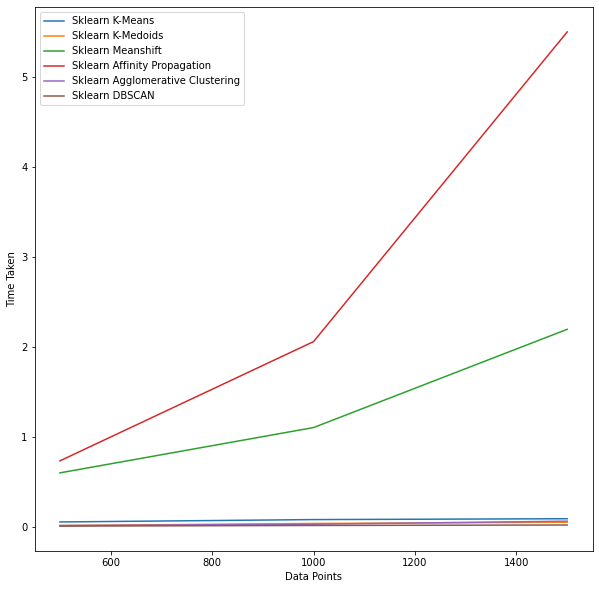

In [18]:
benchmark(kwargs_random, kwargs_affin)

# Simulation Study

This simulation study is intended to round up this project. For this study, I will use Bayne et al. (1980), who compare clustering methods to determine the best clustering method given a specific dataset as a foundation for my simulation study. Since the paper is relatively old, I use this paper as a guideline, but extent / modify the simulation study in various ways as I will outline

which involves defining aims, data-generating mechanisms, estimands, methods, and performance measures (“ADEMP”);

## Data Generating Process

The authors focus on the partitioning of two bivariate normal populations since they argue that generally, techniques that perform poorly in this setup will also perform poorly on more complex data. Extending this, my DGP will allow more than two bivariate normal populations for which I can specify the mean. Since I generate the data, I know the ground truth labels of the observations. I added this feature to have the possibilities to evaluate the results using more metrics.

The DGP has several parameters:


* mode - "custom" data genearation or "spiral" data generation
* n_samples - specifies number of observations within the populations
* centers - number of populations, can also be used to specify means of populations
* cluster_std - standard deviation of the populations
* random_state - 
* cov - Covariance matrix of each population





In [19]:
def simulate_data(mode, n_samples, centers, cluster_std, random_state, cov, truth_labels):
    
    # the make_blobs function does excactly the same thing as when we
    # would specify  a set of bivariate normal populations
    if (mode == "custom"):
        data, true_labels = sk_data.make_blobs(n_samples=n_samples, centers = centers, cluster_std = cluster_std,
                                       random_state=random_state)
        
        data = np.dot(data, cov)
              
        scaler = sk_preprocessing.StandardScaler()
        data_s = scaler.fit_transform(data)
        data_df = pd.DataFrame(data_s, columns = ["x1", "x2"])
        
        data_df["label"] = true_labels
        
        return(data_df)

        
    elif (mode == "spiral"): 
        n_samples = 1000
        t = 1.25 * np.pi * (1 + 3 * np.random.rand(1, n_samples))
        x = t * np.cos(t)
        y = t * np.sin(t)

        data = np.concatenate((x, y))
        data += .7 * np.random.randn(2, n_samples)
        data = data.T
        
        data_df = pd.DataFrame(data, columns = ["x1", "x2"])
        
        return(data_df)

https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_assumptions.html#sphx-glr-auto-examples-cluster-plot-kmeans-assumptions-py

In [20]:
### https://hdbscan.readthedocs.io/en/latest/comparing_clustering_algorithms.html
def simulation_study(reps, data, algorithm, args, kwds):
        
        
    # non spiral data
    metrics = pd.DataFrame(columns = ["FMI", "DBI", "SC", "time"])
    for rep in range(reps):
        start_time = time.time()

        algo = algorithm(*args, **kwds)
        algo_fitted = algo.fit(data[["x1", "x2"]])

        end_time = time.time()

        results = pd.DataFrame(data, columns = ["x1", "x2"])
        results["label"] = algo_fitted.labels_

       # if ("label" in data):
        FMS = round(sk_metrics.fowlkes_mallows_score(data.label, algo_fitted.labels_),8)
            #metrics["FMI"].loc[rep] = FMS
        #metrics.loc[rep] = [FMS, np.nan, np.nan, (end_time - start_time)]
        #else:
        DBI = round(sk_metrics.davies_bouldin_score(data[["x1","x2"]], algo_fitted.labels_),8)
        SC = round(sk_metrics.silhouette_score(data[["x1","x2"]], algo_fitted.labels_),8)
        metrics.loc[rep] = [FMS, DBI,SC, (end_time - start_time)]

            
  
    FMS_avg = round(metrics.FMI.mean(),4)
    DBI_avg = round(metrics.DBI.mean(),4)
    SC_avg = round(metrics.SC.mean(),4)
    fin_metrics = pd.DataFrame(columns = ["Fowlkes Mallows Index", "Davies Bouldin Index", "Silhouette Score", "time", "reps"])
    
   
    fin_metrics.loc['{}'.format(str(algorithm.__name__))] = [FMS_avg,DBI_avg, SC_avg, metrics.time.mean(), reps]
        
    fig, ax = plt.subplots(1,2, figsize = (14,7))

    # True for know ground truth
    if ("label" in data):
        plt.subplot(121)
        ax = sns.scatterplot(x=results.x1, y=results.x2, hue = data.label)
        ax.set_title('Original dataset', fontsize=10)
        
        #fig.suptitle(f"Fowlkes-Mallows Index: {FMS_avg}", fontsize=20)
     
        

    # True for unknow ground truth
    else:
        plt.subplot(121)
        ax = sns.scatterplot(x=results.x1, y=results.x2)# hue = data.label)
        ax.set_title('Original dataset', fontsize=10)
        #fig.suptitle(f"Davies-Bouldin Index: {DBI_avg}\n SC: {SC_avg}", fontsize=20, y = 1.1)
    

    plt.subplot(122)
    ax = sns.scatterplot(x=results.x1, y=results.x2, hue = results.label)
    ax.set_title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=10)
    #plt.text(-0.5, 0.7, 'Clustering took {:.4f} s'.format(metrics.time.mean()), fontsize=14)
    
    return(algo_fitted, fin_metrics)


In [21]:
def simulation_results(nreps, data):
    kmeans, metrics1 = simulation_study(nreps, data, sk_cluster.KMeans, (), {'n_clusters':3,  "init": "random", "n_init": 10, "max_iter": 300})
    kmedoids, metrics2 = simulation_study(nreps, data, skx_cluster.KMedoids, (), {'n_clusters':3,  "init": "random", "max_iter": 300})
    affinity, metrics8 = simulation_study(nreps, data, sk_cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95,"max_iter": 300})
    meanshift, metrics3 = simulation_study(nreps, data, sk_cluster.MeanShift, (),  {'cluster_all':False, "max_iter": 300})
    agglo_complete, metrics4 = simulation_study(nreps, data, sk_cluster.AgglomerativeClustering, (), {'n_clusters':3, 'linkage':'ward'})
    agglo_complete, metrics5 = simulation_study(nreps, data, sk_cluster.AgglomerativeClustering, (), {'n_clusters':3, 'linkage':'complete'})
    agglo_complete, metrics6 = simulation_study(nreps, data, sk_cluster.AgglomerativeClustering, (), {'n_clusters':3, 'linkage':'average'})
    agglo_complete, metrics7 = simulation_study(nreps, data, sk_cluster.AgglomerativeClustering, (), {'n_clusters':3, 'linkage':'single'})
    
    i = ["-","-","-","-","ward","complete","average","single"]
    frames = [metrics1, metrics2,metrics8, metrics3, metrics4, metrics5, metrics6, metrics7]
    result_df = pd.DataFrame(pd.concat(frames), columns =  ["Fowlkes Mallows Index", "Davies Bouldin Index", "Silhouette Score", "time","reps"])
    result_df["further spec."] = i
    
    
    
    
    return(result_df)
    

## Performance Measurement

As pointed out earlier, some introduced metrics for the validation of clstering methods can only be used when the ground truth tabels are known, others only when thoose tables are not known. Nontheless, I will calculate all the introduced metrics for all methods and setups. This will give further insight for the reader to decide which algorithm he should choose if the reader knows or does not know the ground truth tables



## Simulation Study

Lets start with the simulation study. All my code can be found in the auxiliary. As pointed out earlier, visual investigation is crucial for the valdation of the results obtained by different algorithms. Therefore I will add graphs at the end of the tables such that the reader can have a look at the results.



##### Basic Setup

In [44]:
clus_std = 1
cov = [[clus_std**2, 0], [0, clus_std**2]]
data = simulate_data("custom", 1000,3,clus_std,10, cov, True)

KeyboardInterrupt: 

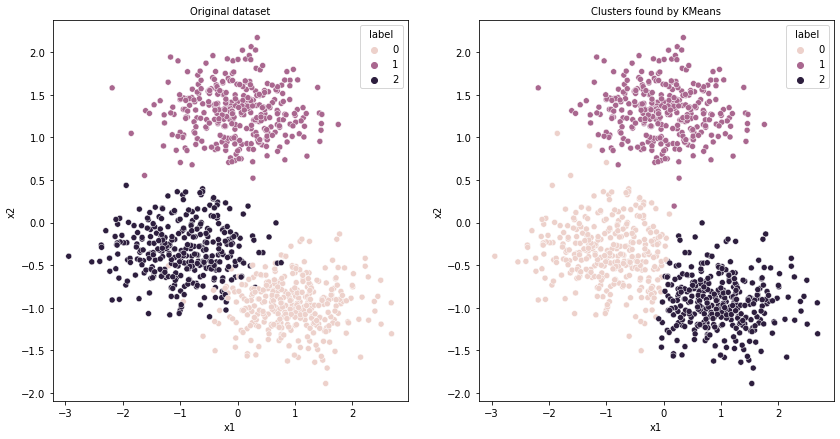

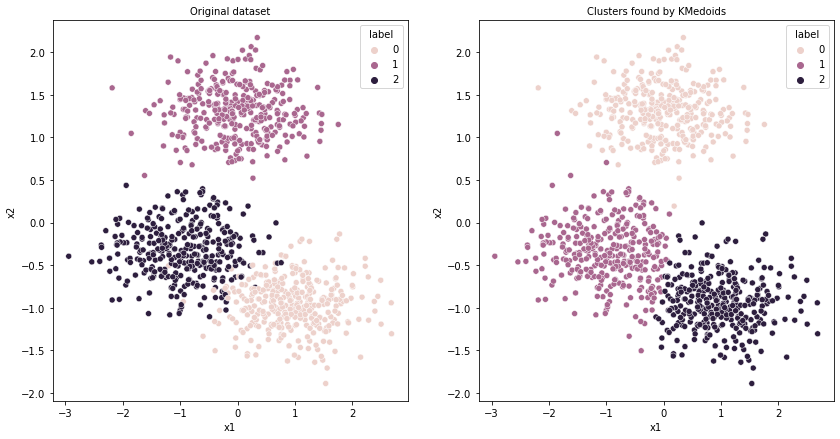

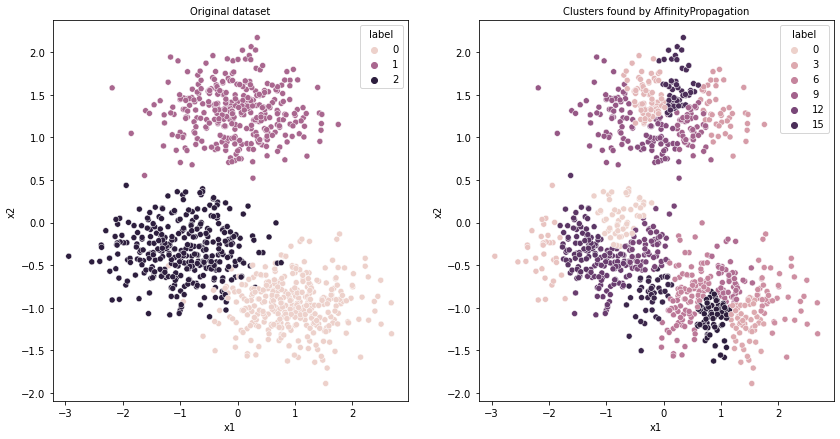

In [45]:
simulation_results(60, data)

In this basic setup, the FMI clearly favours Agglomerative Clustering with the exception of Agglomerative Clustering using the ward linkage. The same is true for the DBI (lower DBI shows better separation between clusters). The Silhouette Score is the highest for the Agglomerative Clustering with complete linkage. W

Silhouette coefficient values range between -1 and 1 where a higher Silhouette Coefficient score relates to a model with better defined clusters and dense clustering. A score of -1 indicates incorrect clustering, a score arround zero shows overlapping clusters. Keep in mind that this coefficient is higher for convex clusters.

A lower Davies-Bouldin index relates to a model with better separation between the clusters. The Davies-Bouldin Index measures the average similarity between the clusters (similarity is thereby measured by comparing the size of the clusters with the distance between the clusters).

FMI The index ranges from 0 to 1. The higher the score, the higher is the similarity between the true labels and the predicted labels. A index of 0 indicates purely independent label assignement, an index of 1 indicates that the label assignments are equal. An advantage of the FMI is that it does not make any assumptions about the structure of the clusters.

In [24]:
clus_std = 4
cov = [[clus_std**2, 0], [0, clus_std**2]]
data = simulate_data("custom", 1000,3,clus_std,10, cov, True)

Fowlkes Mallows Index  Davies Bouldin Index  \
KMeans                                  0.3441                0.7558   
KMedoids                                0.3545                0.7790   
AffinityPropagation                     0.2859                0.7870   
MeanShift                               0.3647                2.6882   
AgglomerativeClustering                 0.3570                0.8220   
AgglomerativeClustering                 0.4299                0.5937   
AgglomerativeClustering                 0.5427                0.4592   
AgglomerativeClustering                 0.5485                0.3591   

                         Silhouette Score      time  reps further spec.  
KMeans                             0.4386  0.028358  60.0             -  
KMedoids                           0.4115  0.003481  60.0             -  
AffinityPropagation                0.3709  0.048703  60.0             -  
MeanShift                          0.3042  0.436664  60.0             -  
AgglomerativeClustering            0.3525  0.003412  60.0          ward  
AgglomerativeClustering            0.4823  0.003174  60.0      complete  
AgglomerativeClustering            0.3356  0.002924  60.0       average  
AgglomerativeClustering            0.3687  0.002801  60.0        single

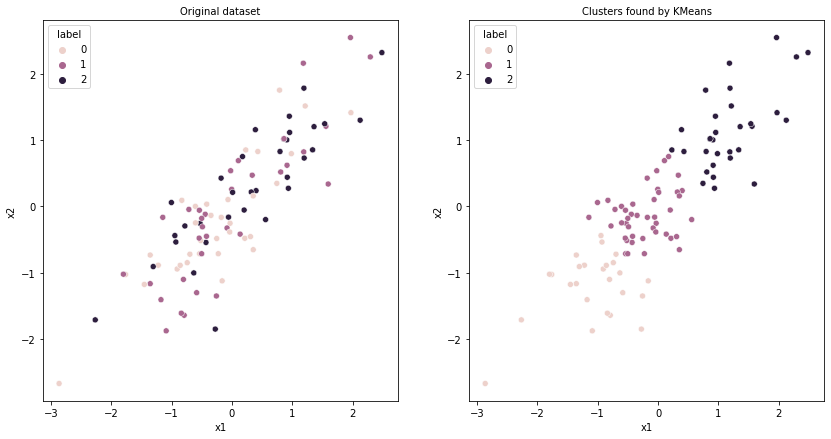

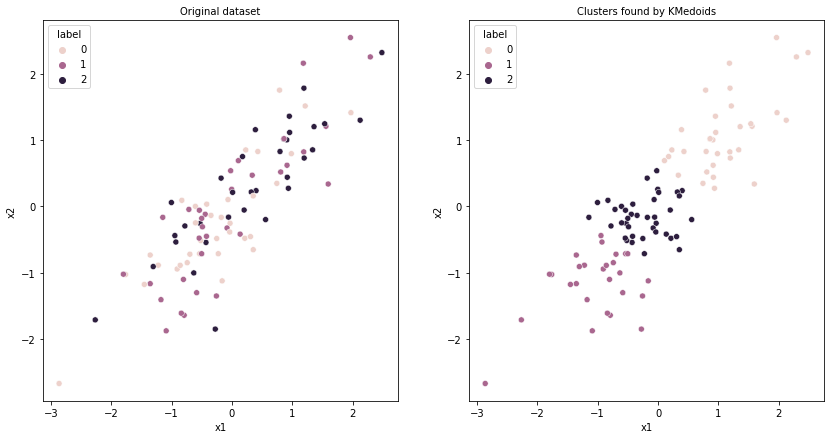

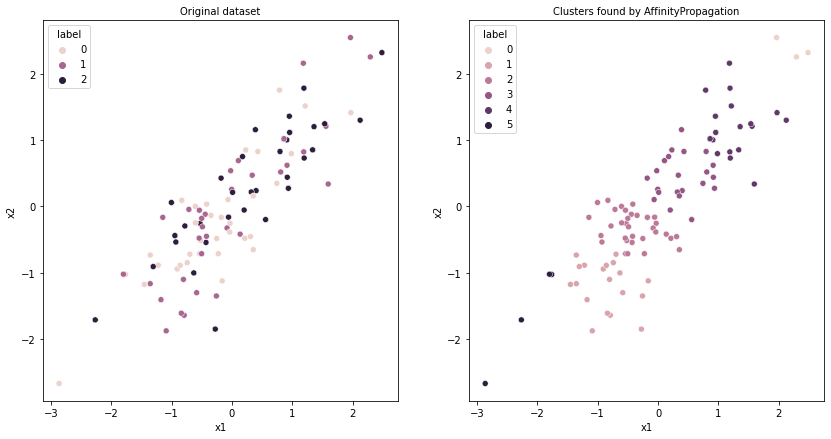

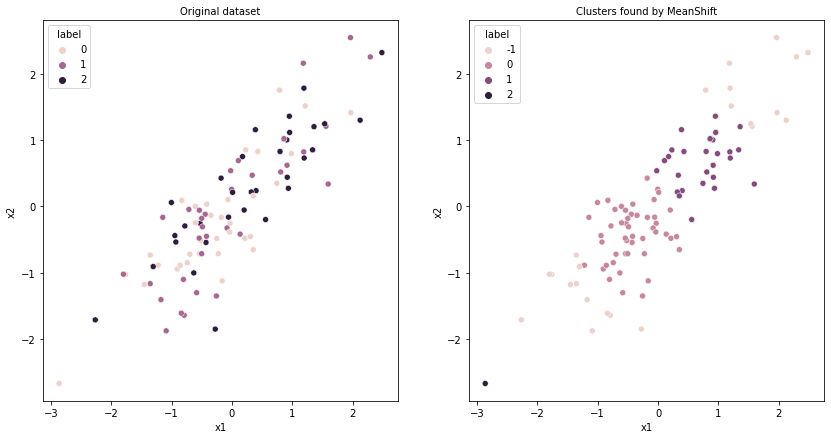

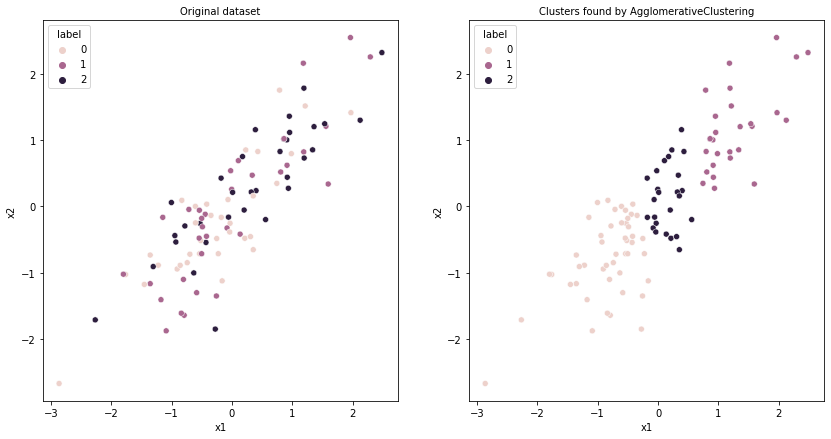

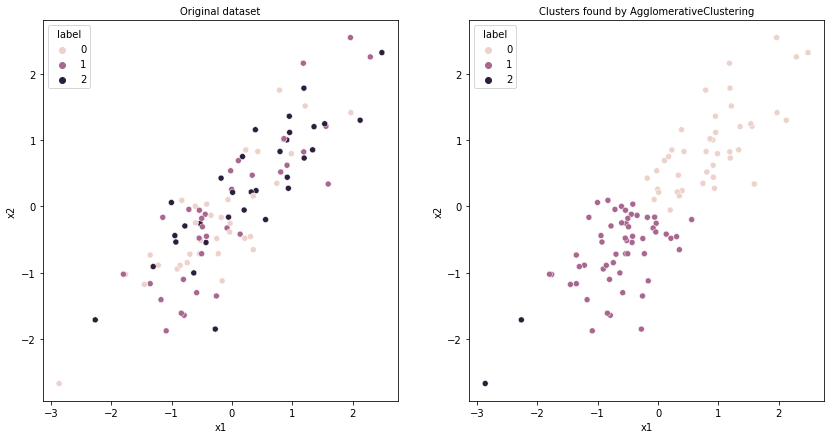

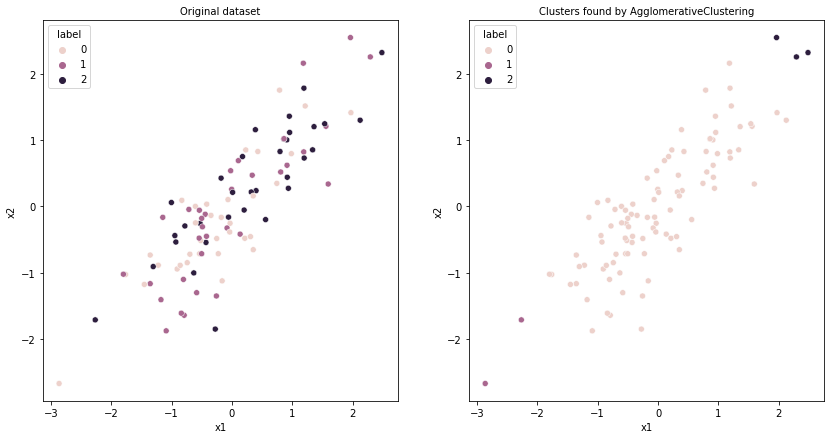

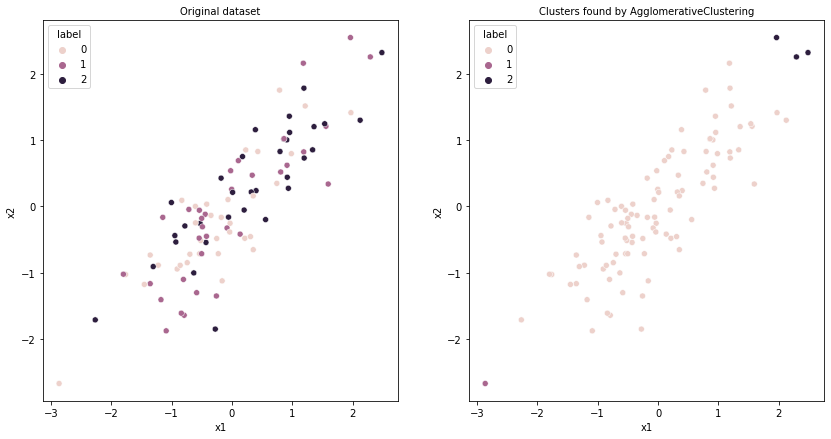

In [35]:
simulation_results(60, data)

The second simulation differs with respect to the covariance of the bivariate normal distributed populations. Again, the FMI favours the Agglomerative Clustering algorithms with the exception of the ward linkage.

In this basic setup, the FMI clearly favours Agglomerative Clustering with the exception of Agglomerative Clustering using the ward linkage. The same is true for the DBI (lower DBI shows better separation between clusters). The Silhouette Score is the highest for the Agglomerative Clustering with complete linkage. W

In [26]:
clus_std = 2
cov = [[clus_std**2, 1], [1, clus_std**2]]
data = simulate_data("custom", 1000,3,clus_std,10, cov, True)

Fowlkes Mallows Index  Davies Bouldin Index  \
KMeans                                  0.3432                0.7575   
KMedoids                                0.3677                0.7765   
AffinityPropagation                     0.2859                0.7870   
MeanShift                               0.3647                2.6882   
AgglomerativeClustering                 0.3570                0.8220   
AgglomerativeClustering                 0.4299                0.5937   
AgglomerativeClustering                 0.5427                0.4592   
AgglomerativeClustering                 0.5485                0.3591   

                         Silhouette Score      time  reps further spec.  
KMeans                             0.4377  0.022354  60.0             -  
KMedoids                           0.4170  0.003137  60.0             -  
AffinityPropagation                0.3709  0.048872  60.0             -  
MeanShift                          0.3042  0.510047  60.0             -  
AgglomerativeClustering            0.3525  0.004554  60.0          ward  
AgglomerativeClustering            0.4823  0.007080  60.0      complete  
AgglomerativeClustering            0.3356  0.003314  60.0       average  
AgglomerativeClustering            0.3687  0.005088  60.0        single

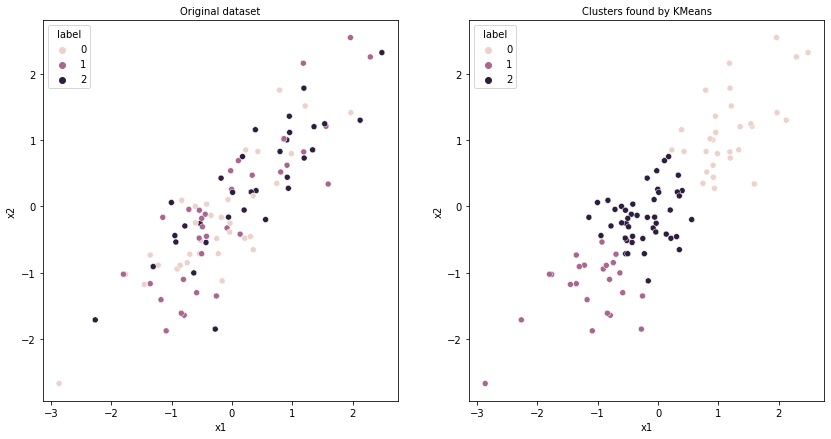

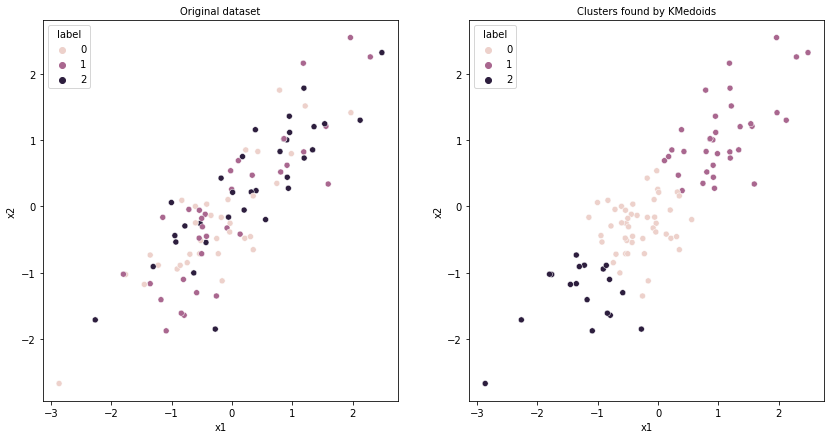

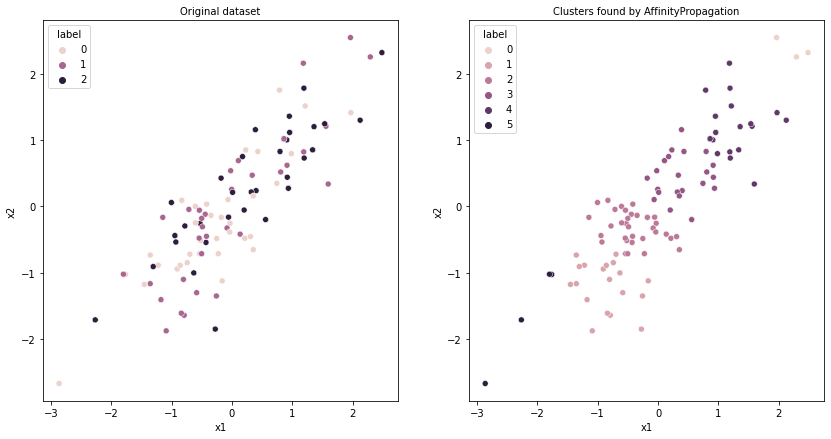

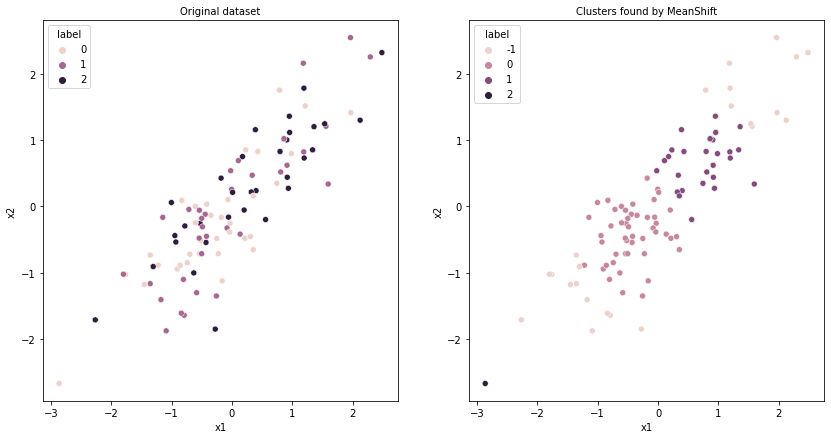

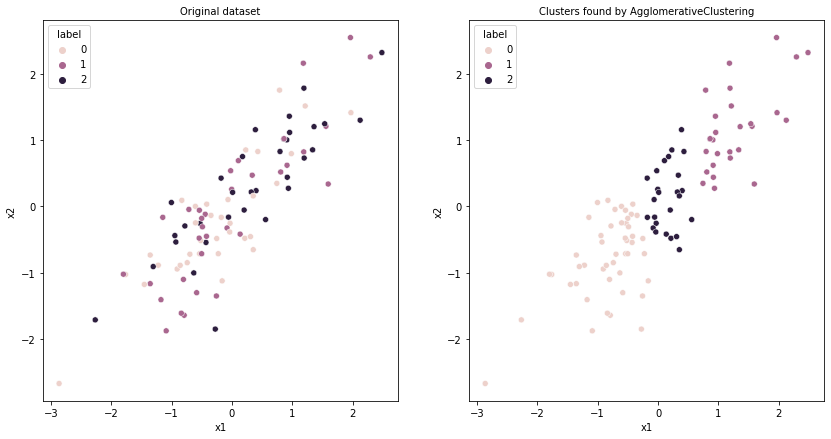

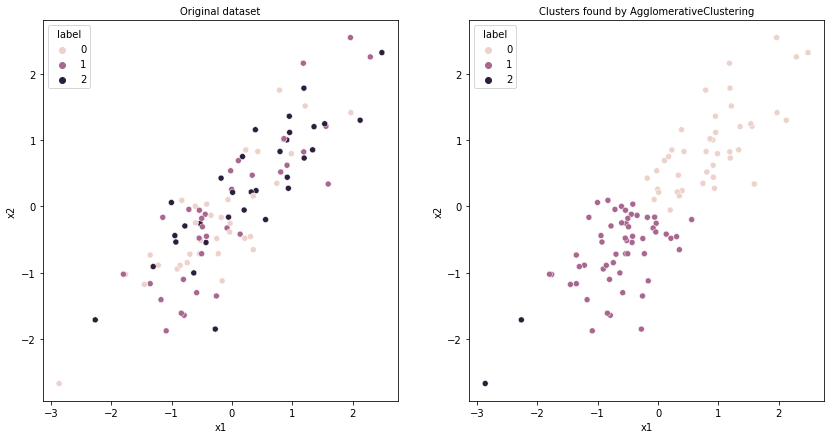

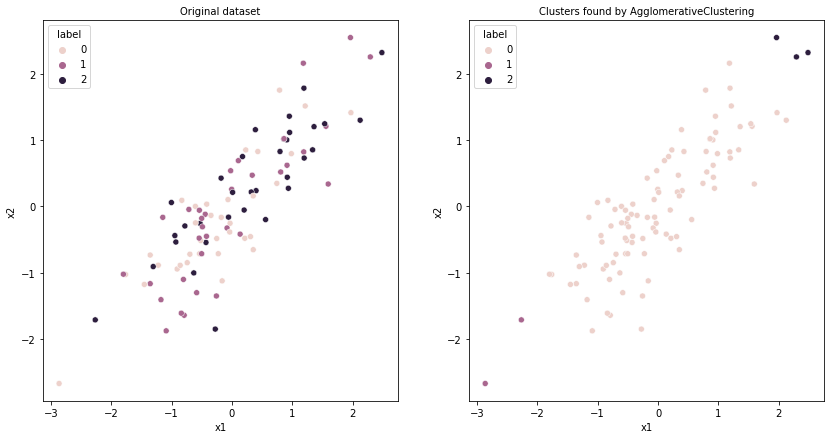

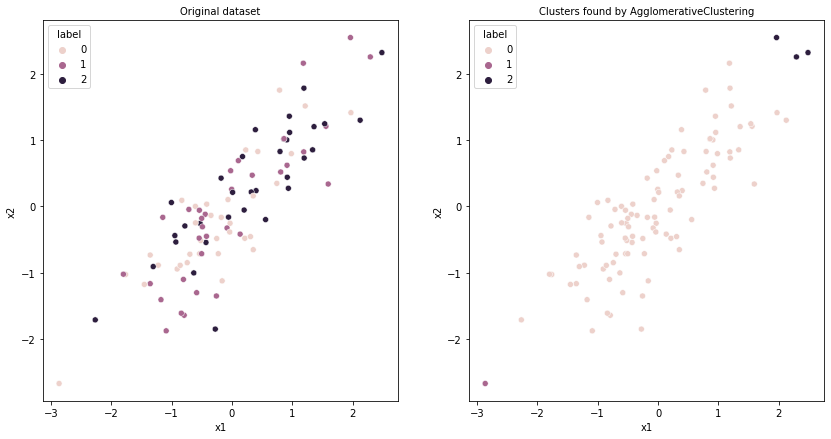

In [36]:
simulation_results(60, data)

In [28]:
clus_std = 2
cov = [[clus_std**2, 2], [2, clus_std**2]]
data = simulate_data("custom", 1000,3,clus_std,10, cov, True)

Fowlkes Mallows Index  Davies Bouldin Index  \
KMeans                                  0.3427                0.7582   
KMedoids                                0.3600                0.7626   
AffinityPropagation                     0.2859                0.7870   
MeanShift                               0.3647                2.6882   
AgglomerativeClustering                 0.3570                0.8220   
AgglomerativeClustering                 0.4299                0.5937   
AgglomerativeClustering                 0.5427                0.4592   
AgglomerativeClustering                 0.5485                0.3591   

                         Silhouette Score      time  reps further spec.  
KMeans                             0.4373  0.046508  60.0             -  
KMedoids                           0.4190  0.004155  60.0             -  
AffinityPropagation                0.3709  0.056813  60.0             -  
MeanShift                          0.3042  0.427197  60.0             -  
AgglomerativeClustering            0.3525  0.002785  60.0          ward  
AgglomerativeClustering            0.4823  0.003974  60.0      complete  
AgglomerativeClustering            0.3356  0.004067  60.0       average  
AgglomerativeClustering            0.3687  0.003566  60.0        single

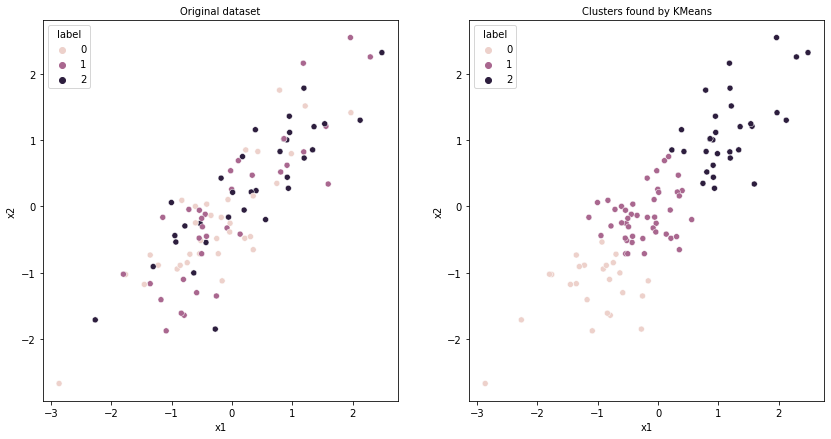

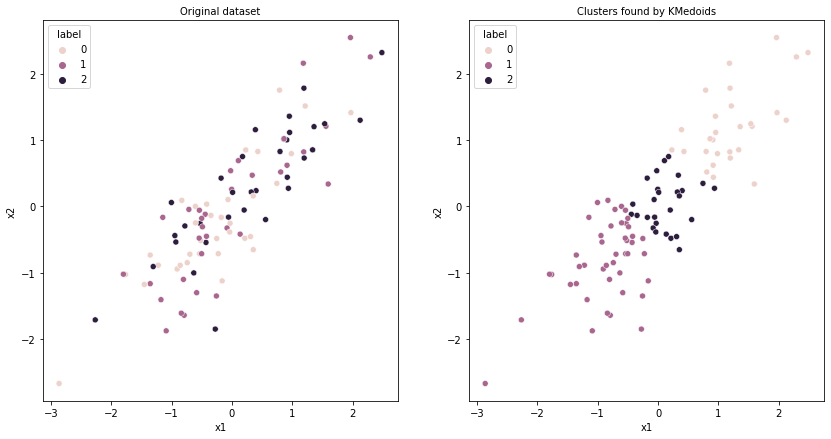

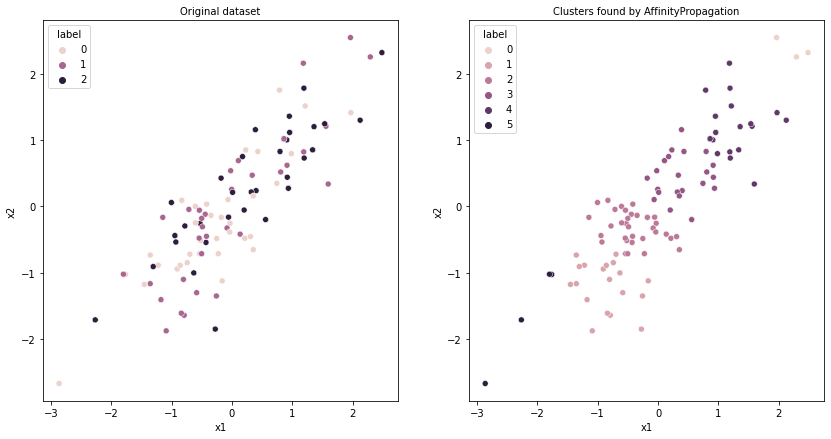

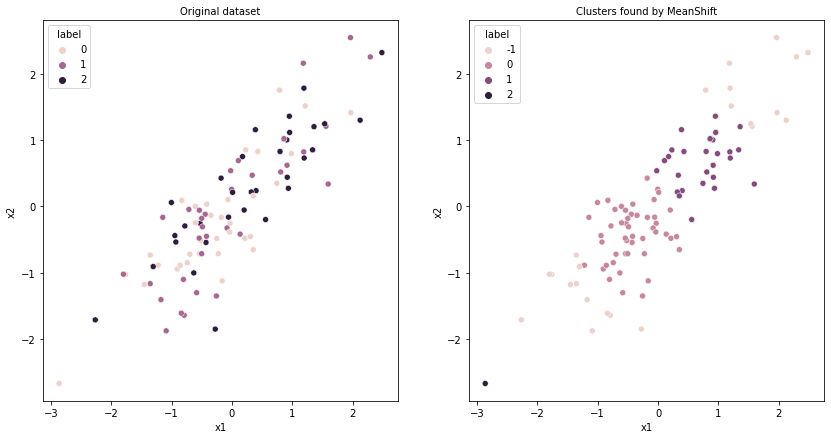

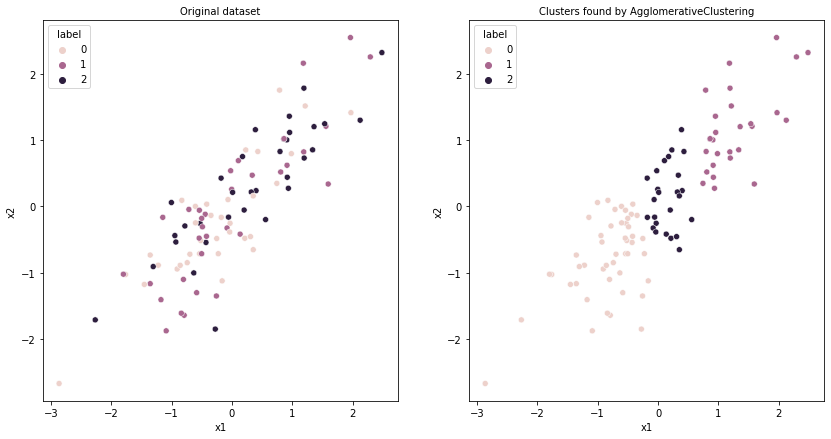

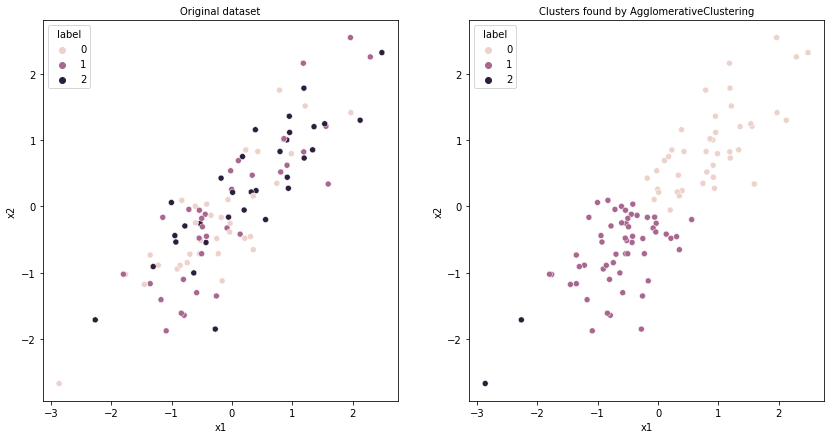

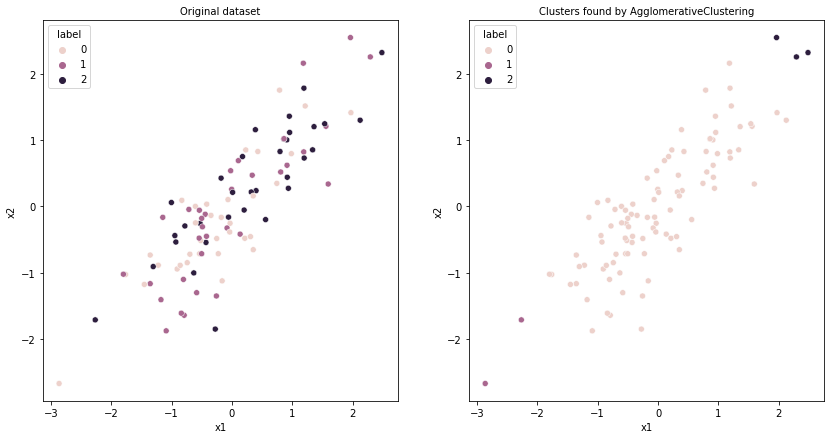

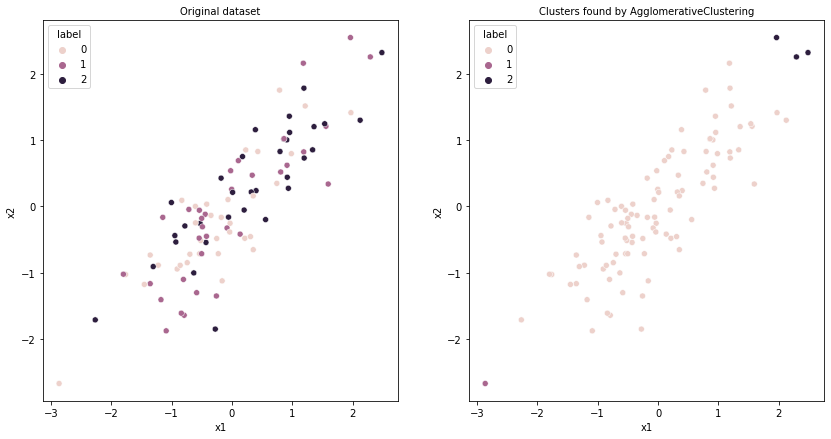

In [37]:
simulation_results(60, data)

In [30]:
clus_std = 2
cov = [[clus_std**2, 2], [2, clus_std**2]]
data = simulate_data("custom", 1000,[[-0.5,-0.5],[0,0],[0.5,0.5]],clus_std,10, cov, True)

Fowlkes Mallows Index  Davies Bouldin Index  \
KMeans                                  0.3434                0.7572   
KMedoids                                0.3648                0.7532   
AffinityPropagation                     0.2859                0.7870   
MeanShift                               0.3647                2.6882   
AgglomerativeClustering                 0.3570                0.8220   
AgglomerativeClustering                 0.4299                0.5937   
AgglomerativeClustering                 0.5427                0.4592   
AgglomerativeClustering                 0.5485                0.3591   

                         Silhouette Score      time  reps further spec.  
KMeans                             0.4380  0.028006  60.0             -  
KMedoids                           0.4234  0.004039  60.0             -  
AffinityPropagation                0.3709  0.053535  60.0             -  
MeanShift                          0.3042  0.453089  60.0             -  
AgglomerativeClustering            0.3525  0.002842  60.0          ward  
AgglomerativeClustering            0.4823  0.003100  60.0      complete  
AgglomerativeClustering            0.3356  0.002617  60.0       average  
AgglomerativeClustering            0.3687  0.002717  60.0        single

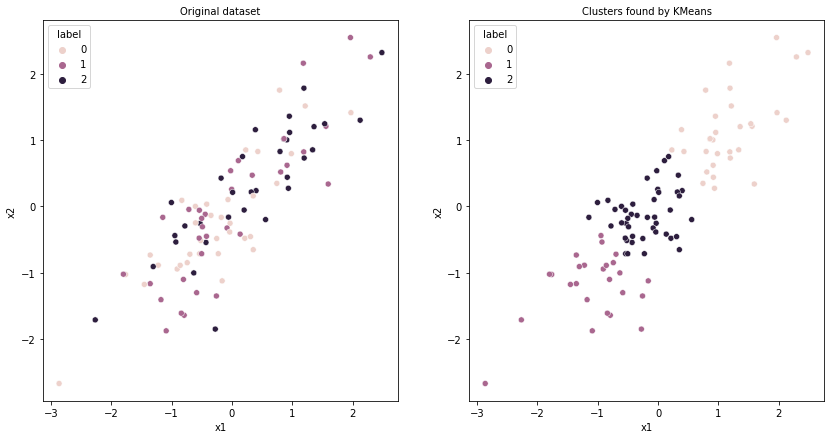

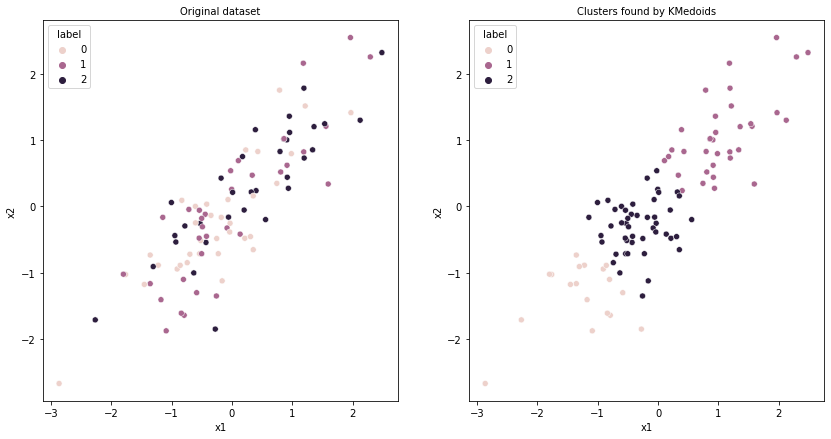

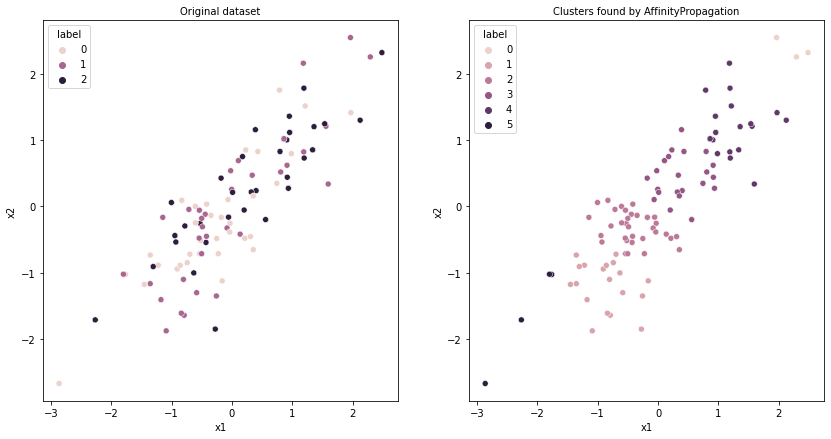

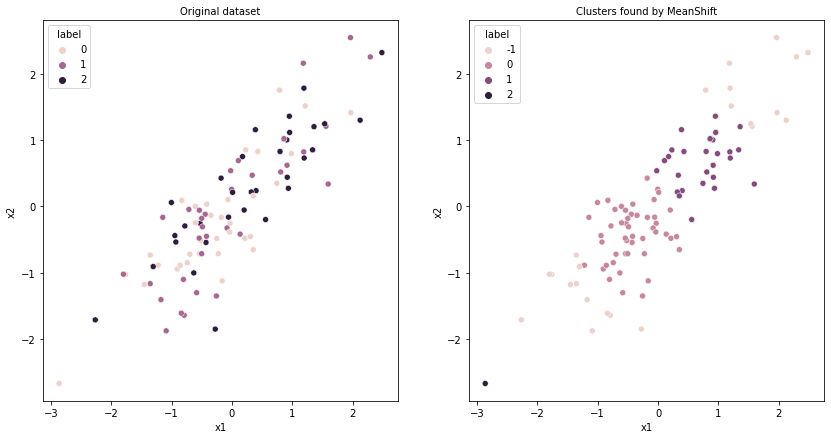

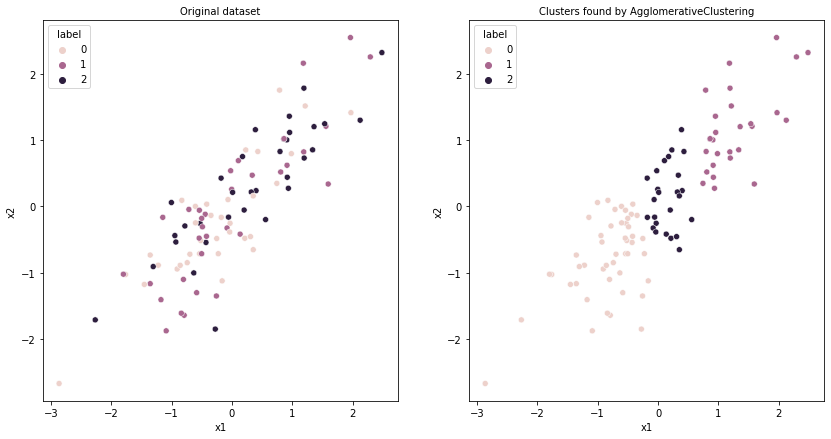

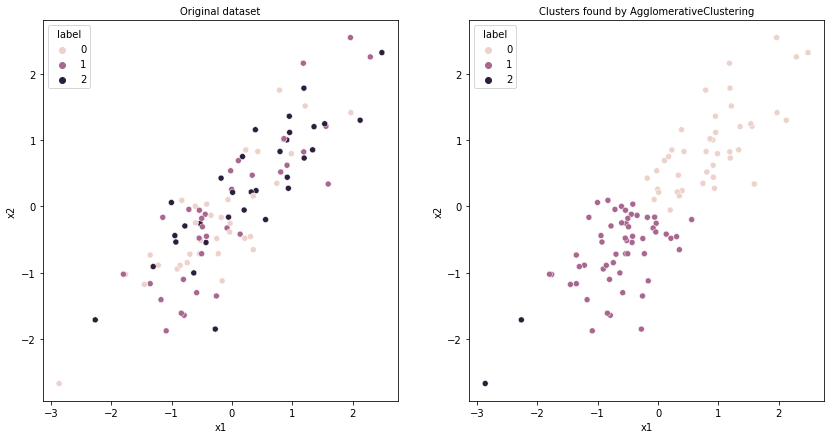

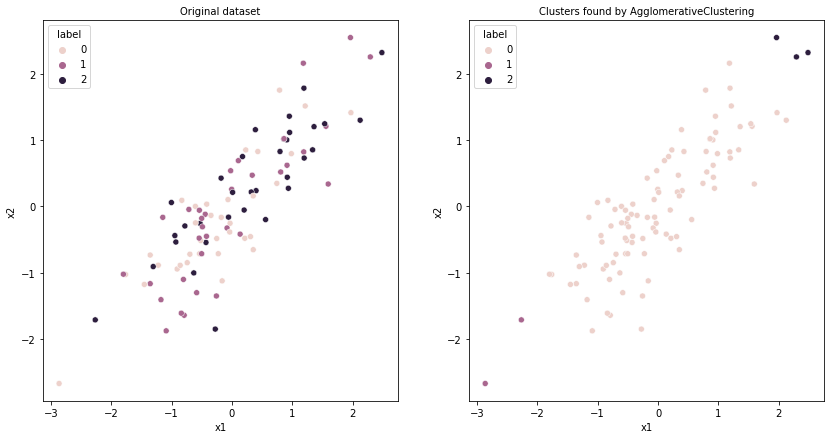

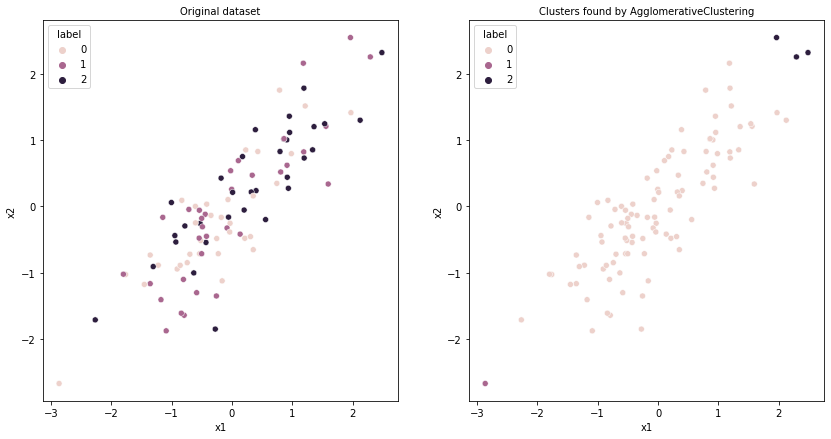

In [38]:
simulation_results(60, data)

In [32]:
clus_std = 2
cov = [[clus_std**2, 2], [2, clus_std**2]]
data = simulate_data("custom", 100,[[-0.5,-0.5],[0,0],[0.5,0.5]],clus_std,10, cov, True)

Fowlkes Mallows Index  Davies Bouldin Index  \
KMeans                                  0.3429                0.7579   
KMedoids                                0.3615                0.7702   
AffinityPropagation                     0.2859                0.7870   
MeanShift                               0.3647                2.6882   
AgglomerativeClustering                 0.3570                0.8220   
AgglomerativeClustering                 0.4299                0.5937   
AgglomerativeClustering                 0.5427                0.4592   
AgglomerativeClustering                 0.5485                0.3591   

                         Silhouette Score      time  reps further spec.  
KMeans                             0.4376  0.038446  60.0             -  
KMedoids                           0.4166  0.003889  60.0             -  
AffinityPropagation                0.3709  0.046803  60.0             -  
MeanShift                          0.3042  0.429004  60.0             -  
AgglomerativeClustering            0.3525  0.002864  60.0          ward  
AgglomerativeClustering            0.4823  0.003130  60.0      complete  
AgglomerativeClustering            0.3356  0.004023  60.0       average  
AgglomerativeClustering            0.3687  0.002527  60.0        single

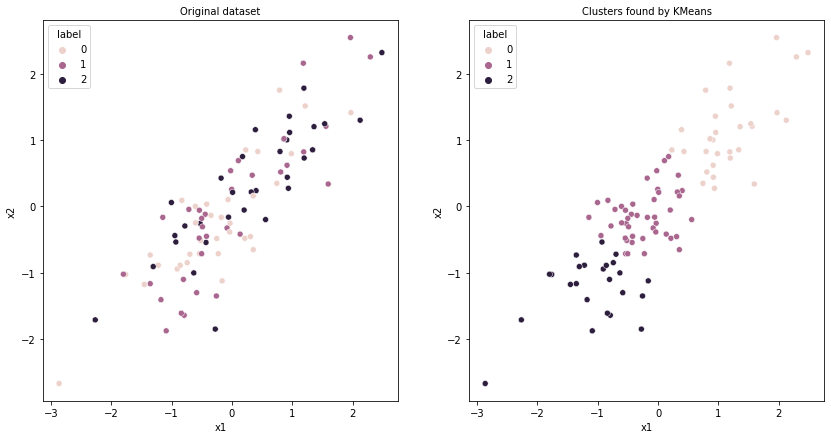

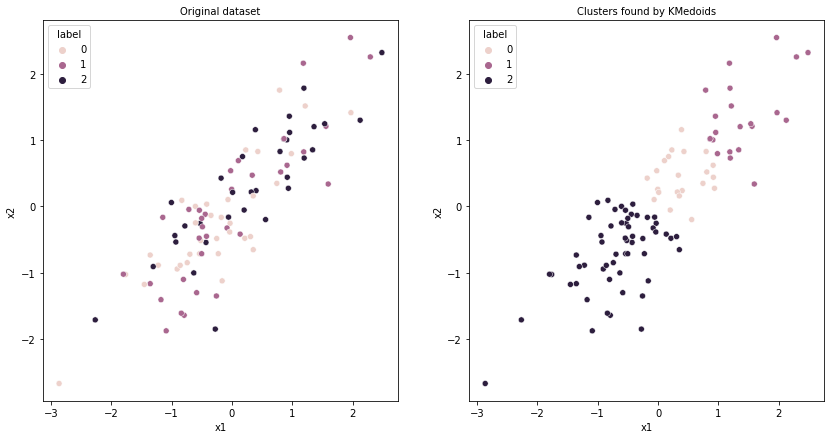

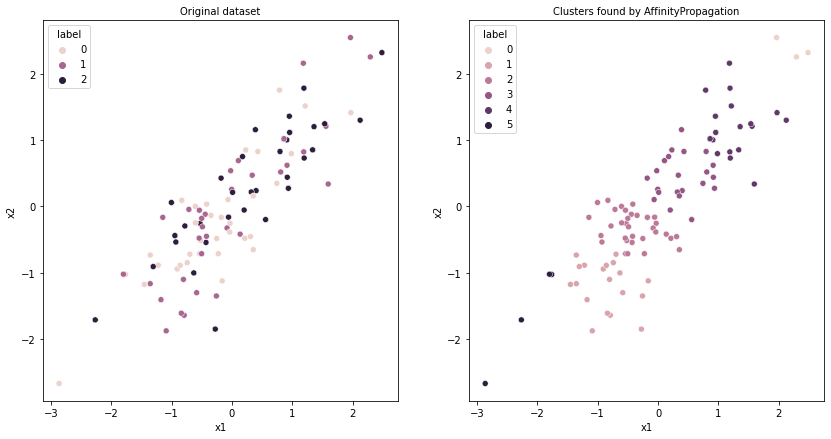

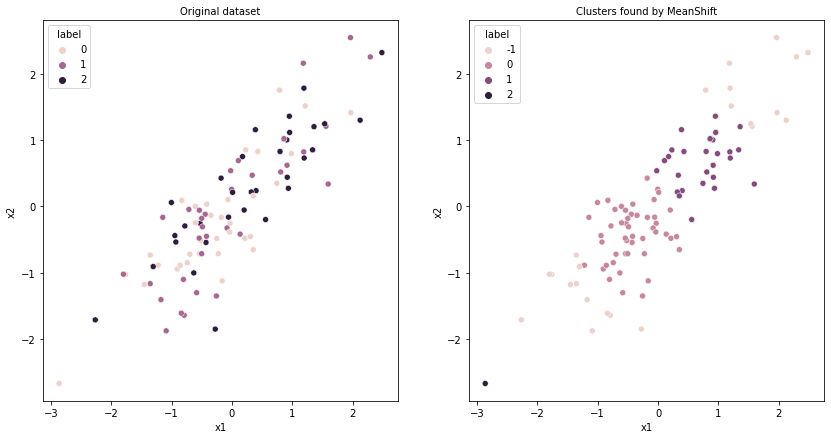

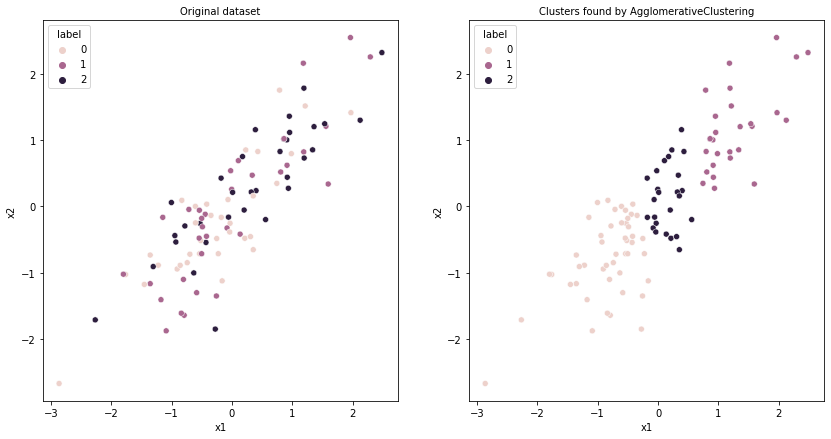

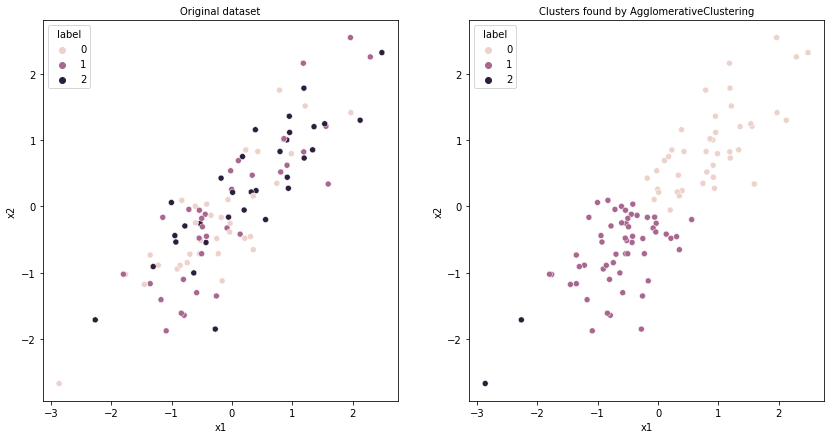

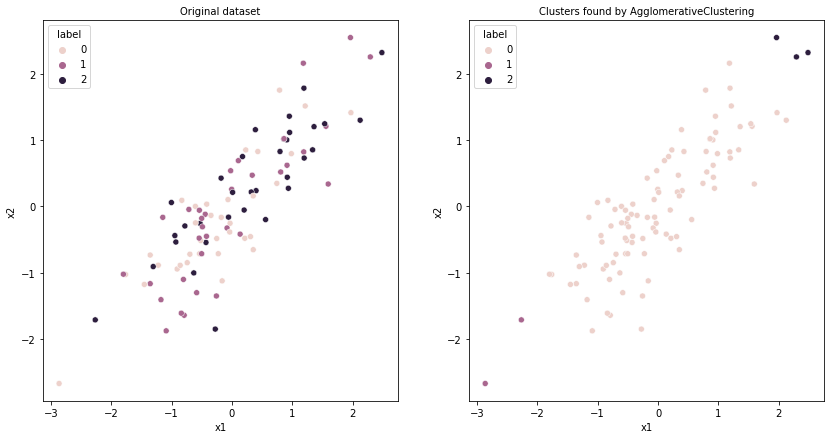

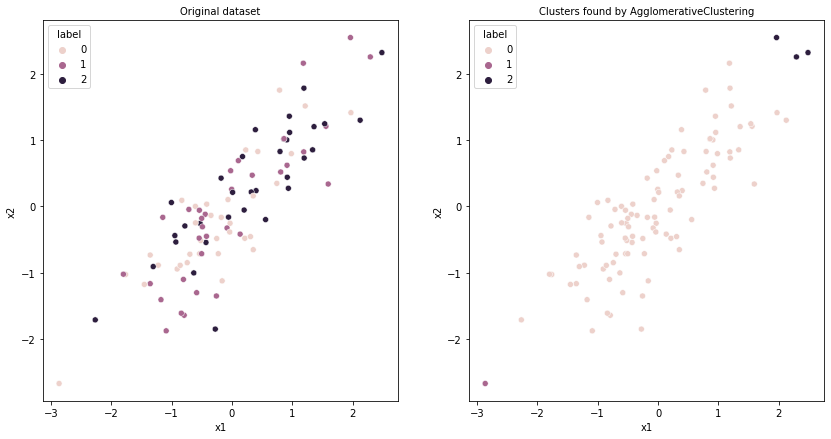

In [39]:
simulation_results(60, data)

# Empirical Application

### Literature

(MacQueen 1967)(https://projecteuclid.org/ebooks/berkeley-symposium-on-mathematical-statistics-and-probability/Proceedings%20of%20the%20Fifth%20Berkeley%20Symposium%20on%20Mathematical%20Statistics%20and%20Probability,%20Volume%201:%20Statistics/chapter/Some%20methods%20for%20classification%20and%20analysis%20of%20multivariate%20observations/bsmsp/1200512992)
